<a href="https://colab.research.google.com/github/VadimKozlov-PIT/Gum-sqeezy/blob/main/%D0%9A%D0%BE%D0%BD%D0%B2%D0%B5%D0%B5%D1%80_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install eli5

     |████████████████████████████████| 112kB 32.0MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
import keras
import seaborn as sns
import eli5
import imblearn


from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.metrics import recall_score, average_precision_score, auc, f1_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE, ADASYN

from eli5.sklearn import PermutationImportance


import os
import tempfile
import cv2
import time
import itertools

%matplotlib inline


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should i

In [4]:
!ls

sample_data


# Построение конвера для нахождения оптимальной нейронной сети

In [5]:
# Загружаем наши данные в google colab
from google.colab import files
files.upload()
# Проверяем что они появились в нашем дериктиве
!ls

Saving ModifyFinData.xlsx to ModifyFinData.xlsx
ModifyFinData.xlsx  sample_data


In [7]:
#Формирруем датафрейм из модифицированных данных
dfm = pd.read_excel('ModifyFinData.xlsx')

#Убираем лишние столбцы
dfm = dfm.drop(['Номер'], axis=1)

#В исходах присутсвует 3 вида: 'CР', 'ПР', 'ПР '. Следовательно нужно избавится от ПР с пробелом
dfm['Исход']=dfm['Исход'].replace('ПР ', 'ПР')

# Далее номеруем СР = 0 и ПР = 1. Есть функции перекодировки, но они почему-то приравнивали СР = 1, чт не очень удобно
dfm['Исход']=dfm['Исход'].replace('ПР', 1)
dfm['Исход']=dfm['Исход'].replace('СР', 0)

#Выводим количество ПР в данных
neg, pos = np.bincount(dfm['Исход'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 12709
    Positive: 661 (5.20% of total)



In [8]:

#Вместо NAN средние значения
from sklearn.impute import SimpleImputer, KNNImputer

df0=dfm[['Рост']]
imputer = KNNImputer(n_neighbors = 3, weights = 'uniform', missing_values=np.NaN)
idf=pd.DataFrame(imputer.fit_transform(df0[::1]))
idf. columns=['Рост'] 
dfm['Рост']=idf

df0=dfm[['Длина шейки матки']]
imputer = KNNImputer(n_neighbors = 3, weights = 'uniform', missing_values=np.NaN)
idf=pd.DataFrame(imputer.fit_transform(df0[::1]))
idf. columns=['Длина шейки матки'] 
dfm['Длина шейки матки']=idf


dfnum_m = dfm[['Возраст','Срок гестации','Вес','Рост','ИМТ','ЧСС','КТР','ТВП','Длина шейки матки','FBHCG MoM','PAPP-A MoM']]
dfcat_m =dfm[['Этническая принадлежность','ИЦН','Паритет','Выкидыши, аборты, ЗБ','ПР 16-30','ПР 31-36','СР','Курение','СД','АГ','АФС','ПЭ','Зачатие','Количество плодов','Хориальность','Исход']]
dfcat_m = dfcat_m.fillna(value='не определенно')
dfm = pd.concat([dfnum_m,dfcat_m],axis=1)

Set = dfm.copy().drop('ИМТ', axis =1)
#Отчистим от пропусков, если все же некоторые остались
Set = Set.dropna()
SetMatrix = Set.copy()
# one-hot-encoding
print('Set',' Исходные признаки: \n', list(Set.columns), '\n')
Set = pd.get_dummies(Set).copy()
print("Признаки после кодировки:\n", list(Set.columns), '\n')

Set  Исходные признаки: 
 ['Возраст', 'Срок гестации', 'Вес', 'Рост', 'ЧСС', 'КТР', 'ТВП', 'Длина шейки матки', 'FBHCG MoM', 'PAPP-A MoM', 'Этническая принадлежность', 'ИЦН', 'Паритет', 'Выкидыши, аборты, ЗБ', 'ПР 16-30', 'ПР 31-36', 'СР', 'Курение', 'СД', 'АГ', 'АФС', 'ПЭ', 'Зачатие', 'Количество плодов', 'Хориальность', 'Исход'] 

Признаки после кодировки:
 ['Возраст', 'Срок гестации', 'Вес', 'Рост', 'ЧСС', 'КТР', 'ТВП', 'Длина шейки матки', 'FBHCG MoM', 'PAPP-A MoM', 'Паритет', 'Выкидыши, аборты, ЗБ', 'Количество плодов', 'Исход', 'Этническая принадлежность_Белая', 'Этническая принадлежность_Восточная Азия', 'Этническая принадлежность_Другая', 'Этническая принадлежность_Негроидная раса', 'Этническая принадлежность_Южная Азия', 'ИЦН_ ', 'ИЦН_Да', 'ИЦН_да', 'ИЦН_не определенно', 'ПР 16-30_0.0', 'ПР 16-30_1.0', 'ПР 16-30_2.0', 'ПР 16-30_3.0', 'ПР 16-30_4.0', 'ПР 16-30_не определенно', 'ПР 31-36_0.0', 'ПР 31-36_1.0', 'ПР 31-36_2.0', 'ПР 31-36_3.0', 'ПР 31-36_4.0', 'ПР 31-36_не определен

In [ ]:
def Split_MinMax_Scalling(SET):
  X = SET.drop('Исход', axis =1)
  Y = SET['Исход']
  #Разделяем на тест и трейн
  X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=2)
  #Масштабируем стандартным образом
  scaler = MinMaxScaler(feature_range=(0, 1))
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test, y_train, y_test

In [ ]:
def Split(SET):
  X = SET.drop('Исход', axis =1)
  Y = SET['Исход']
  #Разделяем на тест и трейн
  X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=2)
  return X_train, X_test, y_train, y_test

In [ ]:
#Разделяем и масштабируем данные
def Split_Standart_Scalling(SET):
  X = SET.drop('Исход', axis =1)
  Y = SET['Исход']
  #Разделяем на тест и трейн
  X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=2)
  #Масштабируем стандартным образом
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  X_train = np.clip(X_train, -5, 5)
  X_test = np.clip(X_test, -5, 5)
  return X_train, X_test, y_train, y_test

In [ ]:


#Получаем данные
X_train, X_test, y_train, y_test = Split_MinMax_Scalling(Set)

# #Применяем SMOTE
# X_train,y_train = Do_SMOTE(X_train, y_train, 0.8)

# # my_model = KerasRegressor(build_fn=create_model2('glorot_normal',X_train,Set4), batch_size=32,epochs=100,verbose=1)    
# # my_model.fit(X_train,y_train)
# model2 = create_model('glorot_normal',X_train,Set)
# model2.compile(loss='binary_crossentropy',optimizer='sgd', metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy'])

# clf = KerasRegressor(build_fn = lambda: model2, batch_size=32,epochs=100,verbose=0)
# clf.fit(X_train,y_train)

# X = Set.drop('Исход', axis = 1)
# perm = PermutationImportance(clf, random_state=1).fit(X_train,y_train)
# eli5.show_weights(perm, feature_names = X.columns.tolist())

In [ ]:
def create_model():


  model = Sequential()
  model.add(Dense(22, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), input_shape=(X_train.shape[1],), activation ='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(11, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), activation ='relu'))
  model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='sgd', metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy'])

  return model

#Получаем данные
X_train, X_test, y_train, y_test = Split_MinMax_Scalling(Set)

model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100, 150, 200]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring=make_scorer(f1_score, average = 'micro'))
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
X_train, X_test, y_train, y_test = Split_MinMax_Scalling(Set)


## Настраиваем количество эпох и батчей для f1 меры

In [ ]:
def create_model():


  model = Sequential()
  model.add(Dense(80, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), input_shape=(X_train.shape[1],), activation ='relu'))
  model.add(Dense(40, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), activation ='relu'))
  model.add(Dense(20, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), activation ='relu'))
  model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='sgd', metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy'])

  return model

X_train, X_test, y_train, y_test = Split_MinMax_Scalling(Set)

model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100, 150, 200]
param_grid = dict(model__batch_size=batch_size, model__epochs=epochs)
kf = KFold(n_splits=4, random_state=0, shuffle=True)
sampler = SMOTE(random_state=0, ratio=0.1)
estimator = Pipeline([("sampler", sampler), 
                       ("model", model)])

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=3, scoring = make_scorer(f1_score, average = 'micro'))
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best: 0.948229 using {'model__batch_size': 60, 'model__epochs': 100}
0.946436 (0.001036) with: {'model__batch_size': 10, 'model__epochs': 10}
0.947701 (0.002455) with: {'model__batch_size': 10, 'model__epochs': 50}
0.943167 (0.007500) with: {'model__batch_size': 10, 'model__epochs': 100}
0.936208 (0.014360) with: {'model__batch_size': 10, 'model__epochs': 150}
0.942008 (0.004808) with: {'model__batch_size': 10, 'model__epochs': 200}
0.946225 (0.002728) with: {'model__batch_size': 20, 'model__epochs': 10}
0.945803 (0.001814) with: {'model__batch_size': 20, 'model__epochs': 50}
0.945276 (0.001801) with: {'model__batch_size': 20, 'model__epochs': 100}
0.924720 (0.034440) with: {'model__batch_size': 20, 'model__epochs': 150}
0.946015 (0.002307) with: {'model__batch_size': 20, 'model__epochs': 200}
0.946120 (0.002582) with: {'model__batch_size': 40, 'model__epochs': 10}
0.945382 (0.003113) with: {'model__batch_size': 40, 'model__epochs': 50}
0.945487 (0.001814) with: {'model__batch_size': 4

## Выбираем способ оптимизации

In [ ]:
def create_model(optimizer='adam'):


  model = Sequential()
  model.add(Dense(80, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), input_shape=(X_train.shape[1],), activation ='relu'))
  model.add(Dense(40, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), activation ='relu'))
  model.add(Dense(20, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), activation ='relu'))
  model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))

  model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy'])
  return model
X_train, X_test, y_train, y_test = Split_MinMax_Scalling(Set)

model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=60, verbose=0)

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(model__optimizer=optimizer)

kf = KFold(n_splits=4, random_state=0, shuffle=True)
sampler = SMOTE(random_state=0, ratio=0.1)
estimator = Pipeline([("sampler", sampler), 
                       ("model", model)])



# define the grid search parameters

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=kf, scoring= make_scorer(f1_score, average = 'micro'))
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best: 0.948650 using {'model__optimizer': 'SGD'}
0.948650 (0.001532) with: {'model__optimizer': 'SGD'}
0.937790 (0.012545) with: {'model__optimizer': 'RMSprop'}
0.946120 (0.002117) with: {'model__optimizer': 'Adagrad'}
0.946120 (0.002117) with: {'model__optimizer': 'Adadelta'}
0.940953 (0.004373) with: {'model__optimizer': 'Adam'}
0.946647 (0.001248) with: {'model__optimizer': 'Adamax'}
0.938528 (0.005229) with: {'model__optimizer': 'Nadam'}


## Сверяем отношение балансировки для SMOTE

In [ ]:
def create_model():


  model = Sequential()
  model.add(Dense(80, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), input_shape=(X_train.shape[1],), activation ='relu'))
  model.add(Dense(40, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), activation ='relu'))
  model.add(Dense(20, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), activation ='relu'))
  model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))

  model.compile(loss='binary_crossentropy',optimizer='sgd', metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy'])
  return model
X_train, X_test, y_train, y_test = Split_MinMax_Scalling(Set)

model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=60, verbose=0)

ratio = np.linspace(0.05, 0.2, 4)
param_grid = dict(sampler__ratio=ratio)

kf = KFold(n_splits=4, random_state=0, shuffle=True)
sampler = SMOTE(random_state=0, ratio=ratio)
estimator = Pipeline([("sampler", sampler), 
                       ("model", model)])



# define the grid search parameters

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=kf, scoring= make_scorer(f1_score, average = 'micro'))
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best: 0.947174 using {'sampler__ratio': 0.1}
nan (nan) with: {'sampler__ratio': 0.05}
0.947174 (0.001313) with: {'sampler__ratio': 0.1}
0.942957 (0.003938) with: {'sampler__ratio': 0.15000000000000002}
0.940426 (0.003076) with: {'sampler__ratio': 0.2}


In [ ]:
Y.shape


(9484,)

## Настраиваем гиперпараметры оптимизатора SGD

In [ ]:
from keras.optimizers import SGD

def create_model(learn_rate=0.01, momentum=0):
	# create model
  optimizer = SGD(lr=learn_rate, momentum=momentum)

  model = Sequential()
  model.add(Dense(80, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), input_shape=(X_train.shape[1],), activation ='relu'))
  model.add(Dense(40, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), activation ='relu'))
  model.add(Dense(20, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), activation ='relu'))
  model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

X_train, X_test, y_train, y_test = Split_MinMax_Scalling(Set)


# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=60, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.9]
param_grid = dict(model__learn_rate=learn_rate, model__momentum=momentum)


kf = KFold(n_splits=4, random_state=0, shuffle=True)
sampler = SMOTE(random_state=0, ratio=0.1)
estimator = Pipeline([("sampler", sampler), 
                       ("model", model)])

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=kf, scoring= make_scorer(f1_score, average = 'micro'))
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best: 0.948861 using {'model__learn_rate': 0.01, 'model__momentum': 0.4}
0.946120 (0.002117) with: {'model__learn_rate': 0.001, 'model__momentum': 0.0}
0.946120 (0.002117) with: {'model__learn_rate': 0.001, 'model__momentum': 0.2}
0.946120 (0.002117) with: {'model__learn_rate': 0.001, 'model__momentum': 0.4}
0.946436 (0.001521) with: {'model__learn_rate': 0.001, 'model__momentum': 0.6}
0.946858 (0.000943) with: {'model__learn_rate': 0.001, 'model__momentum': 0.9}
0.946542 (0.001278) with: {'model__learn_rate': 0.01, 'model__momentum': 0.0}
0.947701 (0.002600) with: {'model__learn_rate': 0.01, 'model__momentum': 0.2}
0.948861 (0.001169) with: {'model__learn_rate': 0.01, 'model__momentum': 0.4}
0.945803 (0.004439) with: {'model__learn_rate': 0.01, 'model__momentum': 0.6}
0.943378 (0.006454) with: {'model__learn_rate': 0.01, 'model__momentum': 0.9}
0.946331 (0.002537) with: {'model__learn_rate': 0.1, 'model__momentum': 0.0}
0.941375 (0.008270) with: {'model__learn_rate': 0.1, 'model__mome

## Выбор функции активации в скрытых слоях

In [ ]:

def create_model(activation='relu'):
	# create model
  model = Sequential()
  model.add(Dense(80, input_shape=(X_train.shape[1],), kernel_initializer='glorot_uniform', activation=activation))
  model.add(Dense(40, kernel_initializer='glorot_uniform', activation=activation))
  model.add(Dense(20, kernel_initializer='glorot_uniform', activation=activation))
  model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))
	# Compile model
  model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.01, momentum=0.4), metrics=['accuracy'])
  return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

X_train, X_test, y_train, y_test = Split_MinMax_Scalling(Set)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=60, verbose=0)
# define the grid search parameters

activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)

kf = KFold(n_splits=4, random_state=0, shuffle=True)
sampler = SMOTE(random_state=0, ratio=0.1)
estimator = Pipeline([("sampler", sampler), 
                       ("model", model)])

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=kf, scoring= make_scorer(f1_score, average = 'micro'))
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best: 0.947912 using {'model__activation': 'tanh'}
0.946120 (0.002117) with: {'model__activation': 'softmax'}
0.945909 (0.001987) with: {'model__activation': 'softplus'}
0.947069 (0.001096) with: {'model__activation': 'softsign'}
0.946436 (0.005867) with: {'model__activation': 'relu'}
0.947912 (0.000966) with: {'model__activation': 'tanh'}
0.946120 (0.002117) with: {'model__activation': 'sigmoid'}
0.946120 (0.002117) with: {'model__activation': 'hard_sigmoid'}
0.946858 (0.001578) with: {'model__activation': 'linear'}


## Выбор способа иницилизации весов 

In [ ]:

def create_model(init_mode_sl='he_normal',init_mode_fl ='glorot_normal', activation= 'relu' ):
	# create model
  model = Sequential()
  model.add(Dense(80, input_shape=(X_train.shape[1],), kernel_initializer=init_mode_sl, activation=activation))
  model.add(Dense(40, kernel_initializer=init_mode_sl, activation=activation))
  model.add(Dense(20, kernel_initializer=init_mode_sl, activation=activation))
  model.add(Dense(1, kernel_initializer=init_mode_fl, activation='sigmoid'))
	# Compile model
  model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.01, momentum=0.4), metrics=['accuracy'])
  return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

X_train, X_test, y_train, y_test = Split_MinMax_Scalling(Set)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=60, verbose=0)
# define the grid search parameters
init_mode_sl = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
init_mode_fl = ['glorot_normal','glorot_uniform']
activation = ['relu','tanh']

param_grid = dict(model__init_mode_sl=init_mode_sl, model__init_mode_fl=init_mode_fl, model__activation=activation)

kf = KFold(n_splits=4, random_state=0, shuffle=True) 
sampler = SMOTE(random_state=0, ratio=0.1) 
estimator = Pipeline([("sampler", sampler), 
                       ("model", model)])

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=kf, scoring= make_scorer(f1_score, average = 'micro'))
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best: 0.949283 using {'model__activation': 'relu', 'model__init_mode_fl': 'glorot_uniform', 'model__init_mode_sl': 'glorot_uniform'}
0.943800 (0.001871) with: {'model__activation': 'relu', 'model__init_mode_fl': 'glorot_normal', 'model__init_mode_sl': 'uniform'}
0.948756 (0.000472) with: {'model__activation': 'relu', 'model__init_mode_fl': 'glorot_normal', 'model__init_mode_sl': 'lecun_uniform'}
0.944116 (0.001350) with: {'model__activation': 'relu', 'model__init_mode_fl': 'glorot_normal', 'model__init_mode_sl': 'normal'}
0.946120 (0.002117) with: {'model__activation': 'relu', 'model__init_mode_fl': 'glorot_normal', 'model__init_mode_sl': 'zero'}
0.947701 (0.001713) with: {'model__activation': 'relu', 'model__init_mode_fl': 'glorot_normal', 'model__init_mode_sl': 'glorot_normal'}
0.947807 (0.002756) with: {'model__activation': 'relu', 'model__init_mode_fl': 'glorot_normal', 'model__init_mode_sl': 'glorot_uniform'}
0.946225 (0.002395) with: {'model__activation': 'relu', 'model__init_mod

## Настройка отсева (dropout) и регуляризации нейронов

In [ ]:
import numpy

In [ ]:

from keras.constraints import maxnorm

def create_model(dropout_rate_1=0.1,dropout_rate_2=0.0 ):
	# create model
  model = Sequential()
  model.add(Dense(80, input_shape=(X_train.shape[1],), kernel_initializer='glorot_uniform', activation='relu', kernel_constraint=maxnorm(3)))
  model.add(Dropout(dropout_rate_1))
  model.add(Dense(40, kernel_initializer='glorot_uniform', activation='relu', kernel_constraint=maxnorm(3)))
  model.add(Dropout(dropout_rate_2))
  model.add(Dense(20, kernel_initializer='glorot_uniform', activation='relu', kernel_constraint=maxnorm(3)))
  model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))
	# Compile model
  model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.01, momentum=0.4), metrics=['accuracy'])
  return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)


# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=60, verbose=0)
# define the grid search parameters
dropout_rate_1 = [ 0.1, 0.3, 0.5]
dropout_rate_2 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

param_grid = dict(model__dropout_rate_1=dropout_rate_1, model__dropout_rate_2=dropout_rate_2)

kf = KFold(n_splits=4, random_state=0, shuffle=True)
sampler = SMOTE(random_state=0, ratio=0.1)
estimator = Pipeline([("sampler", sampler), 
                       ("model", model)])

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=kf, scoring= make_scorer(f1_score, average = 'micro'))
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best: 0.947596 using {'model__dropout_rate_1': 0.1, 'model__dropout_rate_2': 0.1}
0.947385 (0.000753) with: {'model__dropout_rate_1': 0.1, 'model__dropout_rate_2': 0.0}
0.947596 (0.001379) with: {'model__dropout_rate_1': 0.1, 'model__dropout_rate_2': 0.1}
0.946752 (0.001091) with: {'model__dropout_rate_1': 0.1, 'model__dropout_rate_2': 0.2}
0.947174 (0.000810) with: {'model__dropout_rate_1': 0.1, 'model__dropout_rate_2': 0.3}
0.945593 (0.001300) with: {'model__dropout_rate_1': 0.1, 'model__dropout_rate_2': 0.4}
0.945171 (0.002937) with: {'model__dropout_rate_1': 0.1, 'model__dropout_rate_2': 0.5}
0.945171 (0.001075) with: {'model__dropout_rate_1': 0.1, 'model__dropout_rate_2': 0.6}
0.945487 (0.001346) with: {'model__dropout_rate_1': 0.1, 'model__dropout_rate_2': 0.7}
0.946120 (0.002117) with: {'model__dropout_rate_1': 0.1, 'model__dropout_rate_2': 0.8}
0.946120 (0.002117) with: {'model__dropout_rate_1': 0.1, 'model__dropout_rate_2': 0.9}
0.946647 (0.001248) with: {'model__dropout_rate_

# Итоговая модель

In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(80, input_shape=(X_train.shape[1],), kernel_initializer='glorot_uniform', activation='relu', kernel_constraint=maxnorm(3)))
  model.add(Dropout(0.1))
  model.add(Dense(40, kernel_initializer='glorot_uniform', activation='relu', kernel_constraint=maxnorm(3)))
  model.add(Dense(20, kernel_initializer='glorot_uniform', activation='relu', kernel_constraint=maxnorm(3)))
  model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))
	# Compile model
  model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.01, momentum=0.4), metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy',tf.keras.metrics.SpecificityAtSensitivity(0.5)])
  return model

model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=60, verbose=0)


In [ ]:
 from imblearn.over_sampling import SMOTE
 def Do_SMOTE(X_train,y_train,rat):
  smote = SMOTE(ratio=rat)
  X_train, y_train = smote.fit_sample(X_train, y_train)
  return X_train, y_train

In [ ]:
import h5py
from keras.callbacks import EarlyStopping, ModelCheckpoint
#Получаем данные
X_train, X_test, y_train, y_test = Split_MinMax_Scalling(Set)
#Находми нужные веса, для ПР будут большими, для СР малыми
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)

#Применяем ADASYN
X_train,y_train = Do_SMOTE(X_train, y_train, 0.1)

#Вызываем нс
modelfinal = create_model()
#применяем раннюю остановку  Не забудь менять номер метрики! всрато конечно
#es = EarlyStopping(monitor='val_specificity_at_sensitivity_23', mode='max', verbose=1, patience=20)
#Применение сохранения лучшей модели
mc = ModelCheckpoint('best_modelFinal2.h5', monitor='val_specificity_at_sensitivity_13', mode='max', save_best_only=True, verbose=1)
modelfinal.fit(X_train,y_train, batch_size=60,epochs=200,verbose=0,validation_data=(X_test,y_test), callbacks=[mc])

In [ ]:
!ls

best_modelFinal2.h5  best_modelFinalROC.h5  conf-MLP.png	sample_data
best_modelFinal.h5   conf-MlpKeras.png	    ModifyFinData.xlsx


In [ ]:
from google.colab import files
files.download("best_modelFinalROC.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.title('Модель c оптимальными гиперпараметрами',fontdict=4)
# plt.xlabel("Номер эпохи")
# plt.ylabel("")
plt.plot(modelfinal.history.history[list(modelfinal.history.history.keys())[6]], label =list(modelfinal.history.history.keys())[6] , )
plt.plot(modelfinal.history.history[list(modelfinal.history.history.keys())[4]], label =list(modelfinal.history.history.keys())[4] )
plt.plot(modelfinal.history.history[list(modelfinal.history.history.keys())[7]], label =list(modelfinal.history.history.keys())[7] )
#plt.plot(Glorot_model_n.history.history[list(Glorot_model_n.history.history.keys())[7]], label =list(Glorot_model_n.history.history.keys())[7] )
#plt.plot(uniform_model.history.history['val_accuracy'], label ='Случайная иницилизация')
# plt.legend()


In [ ]:
from keras.models import load_model
saved_model = load_model('best_modelFinal2.h5')

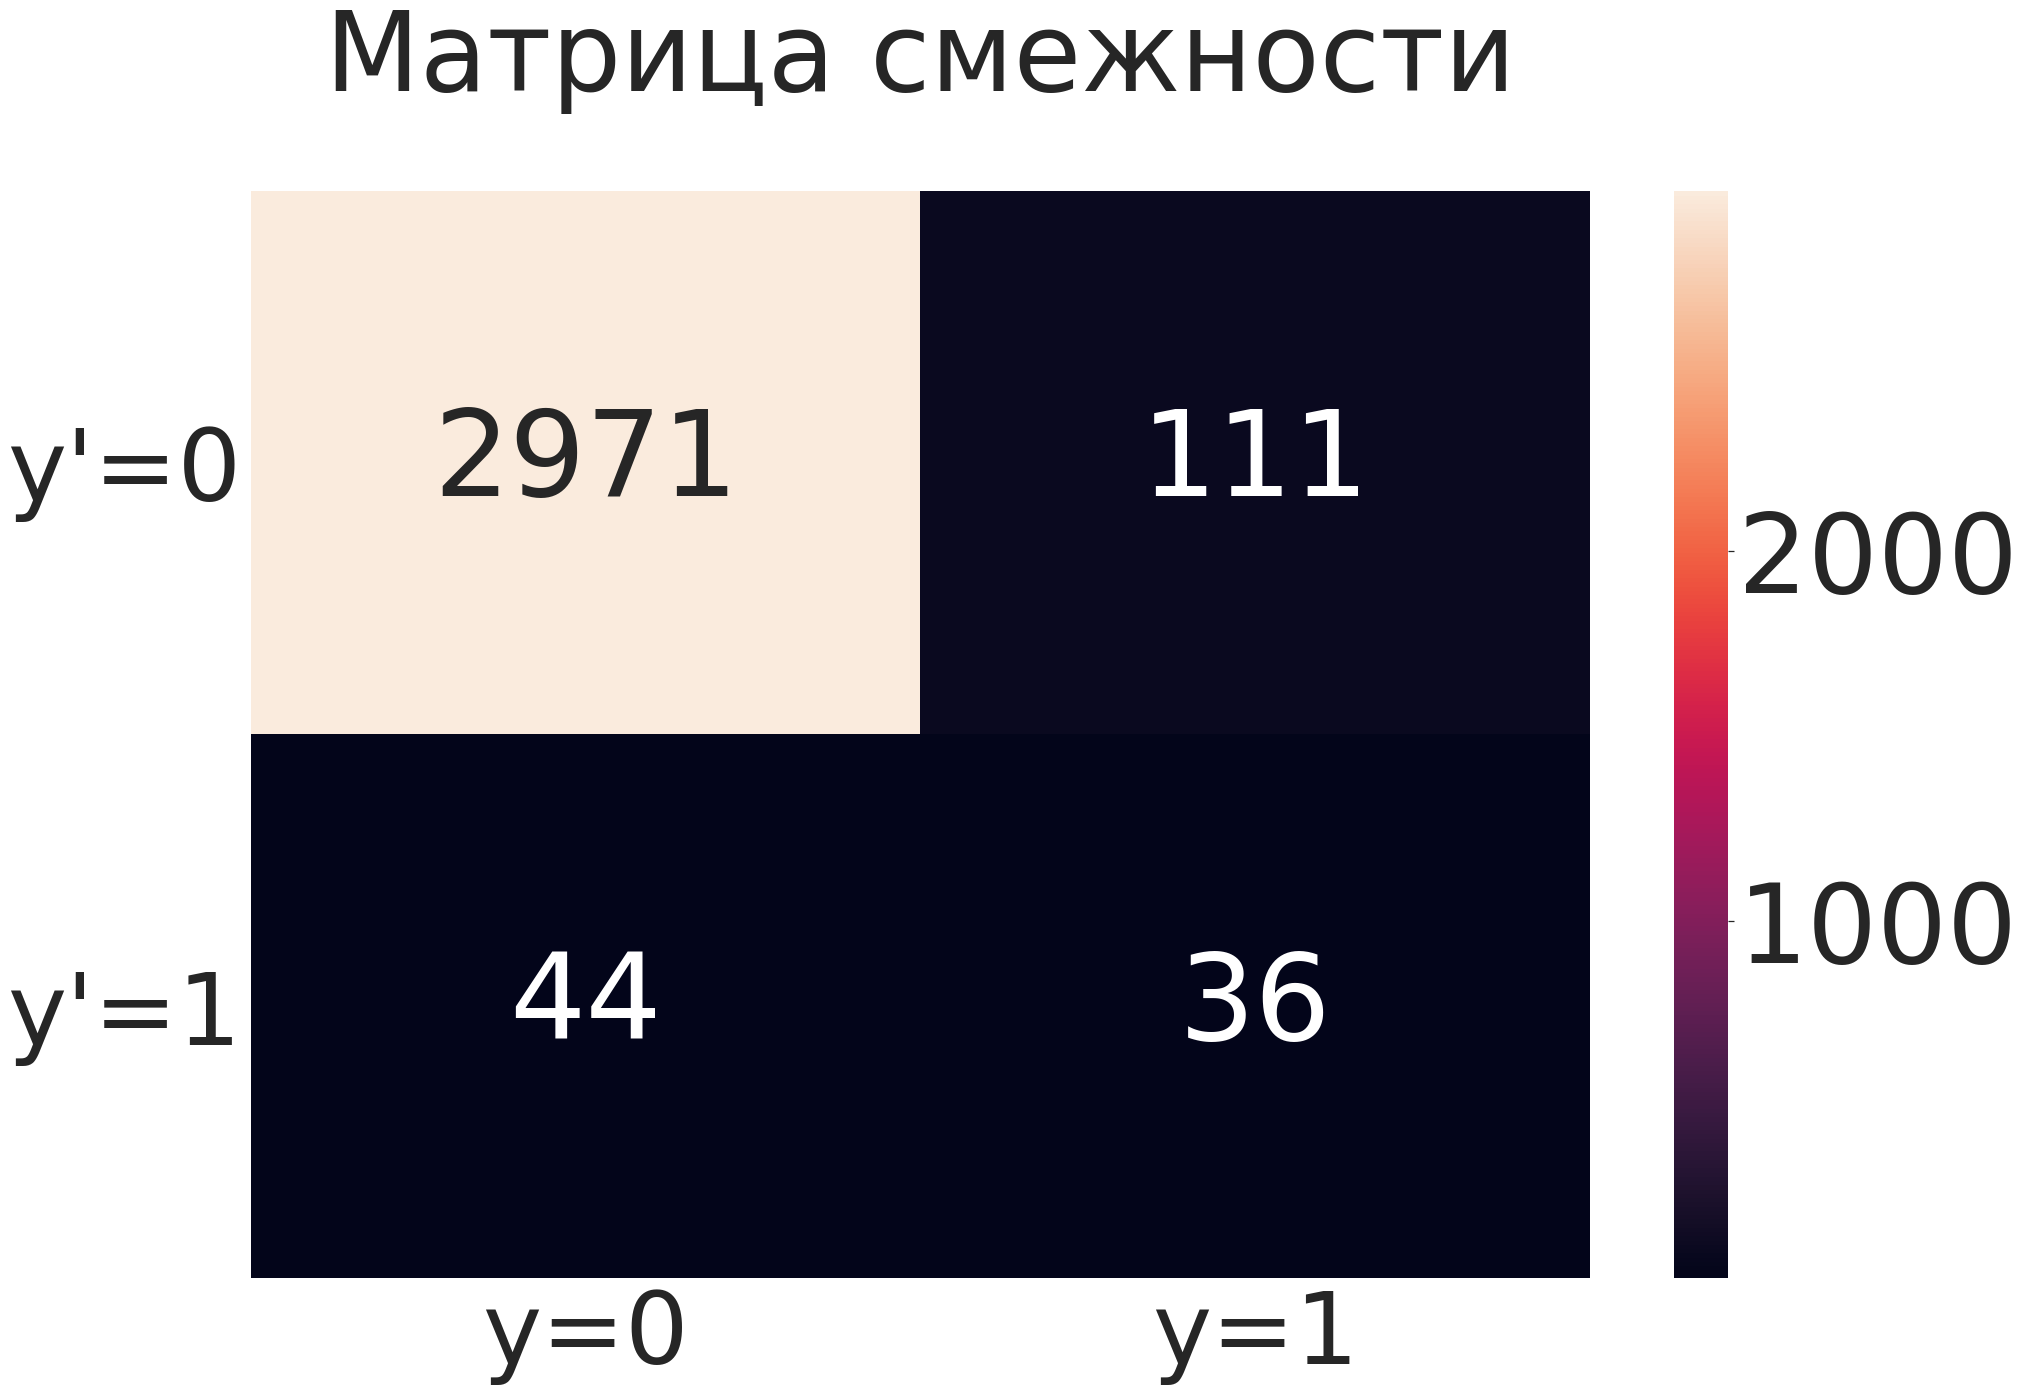

In [ ]:
y_pred=saved_model.predict(X_test)
y_pred = (y_pred>0.5)
plot_confusion_matrix(y_test, y_pred, 'MLP')

Test accuracy: 0.9550917141049968
Test precision: 0.5409836065573771
Test recall: 0.22448979591836735


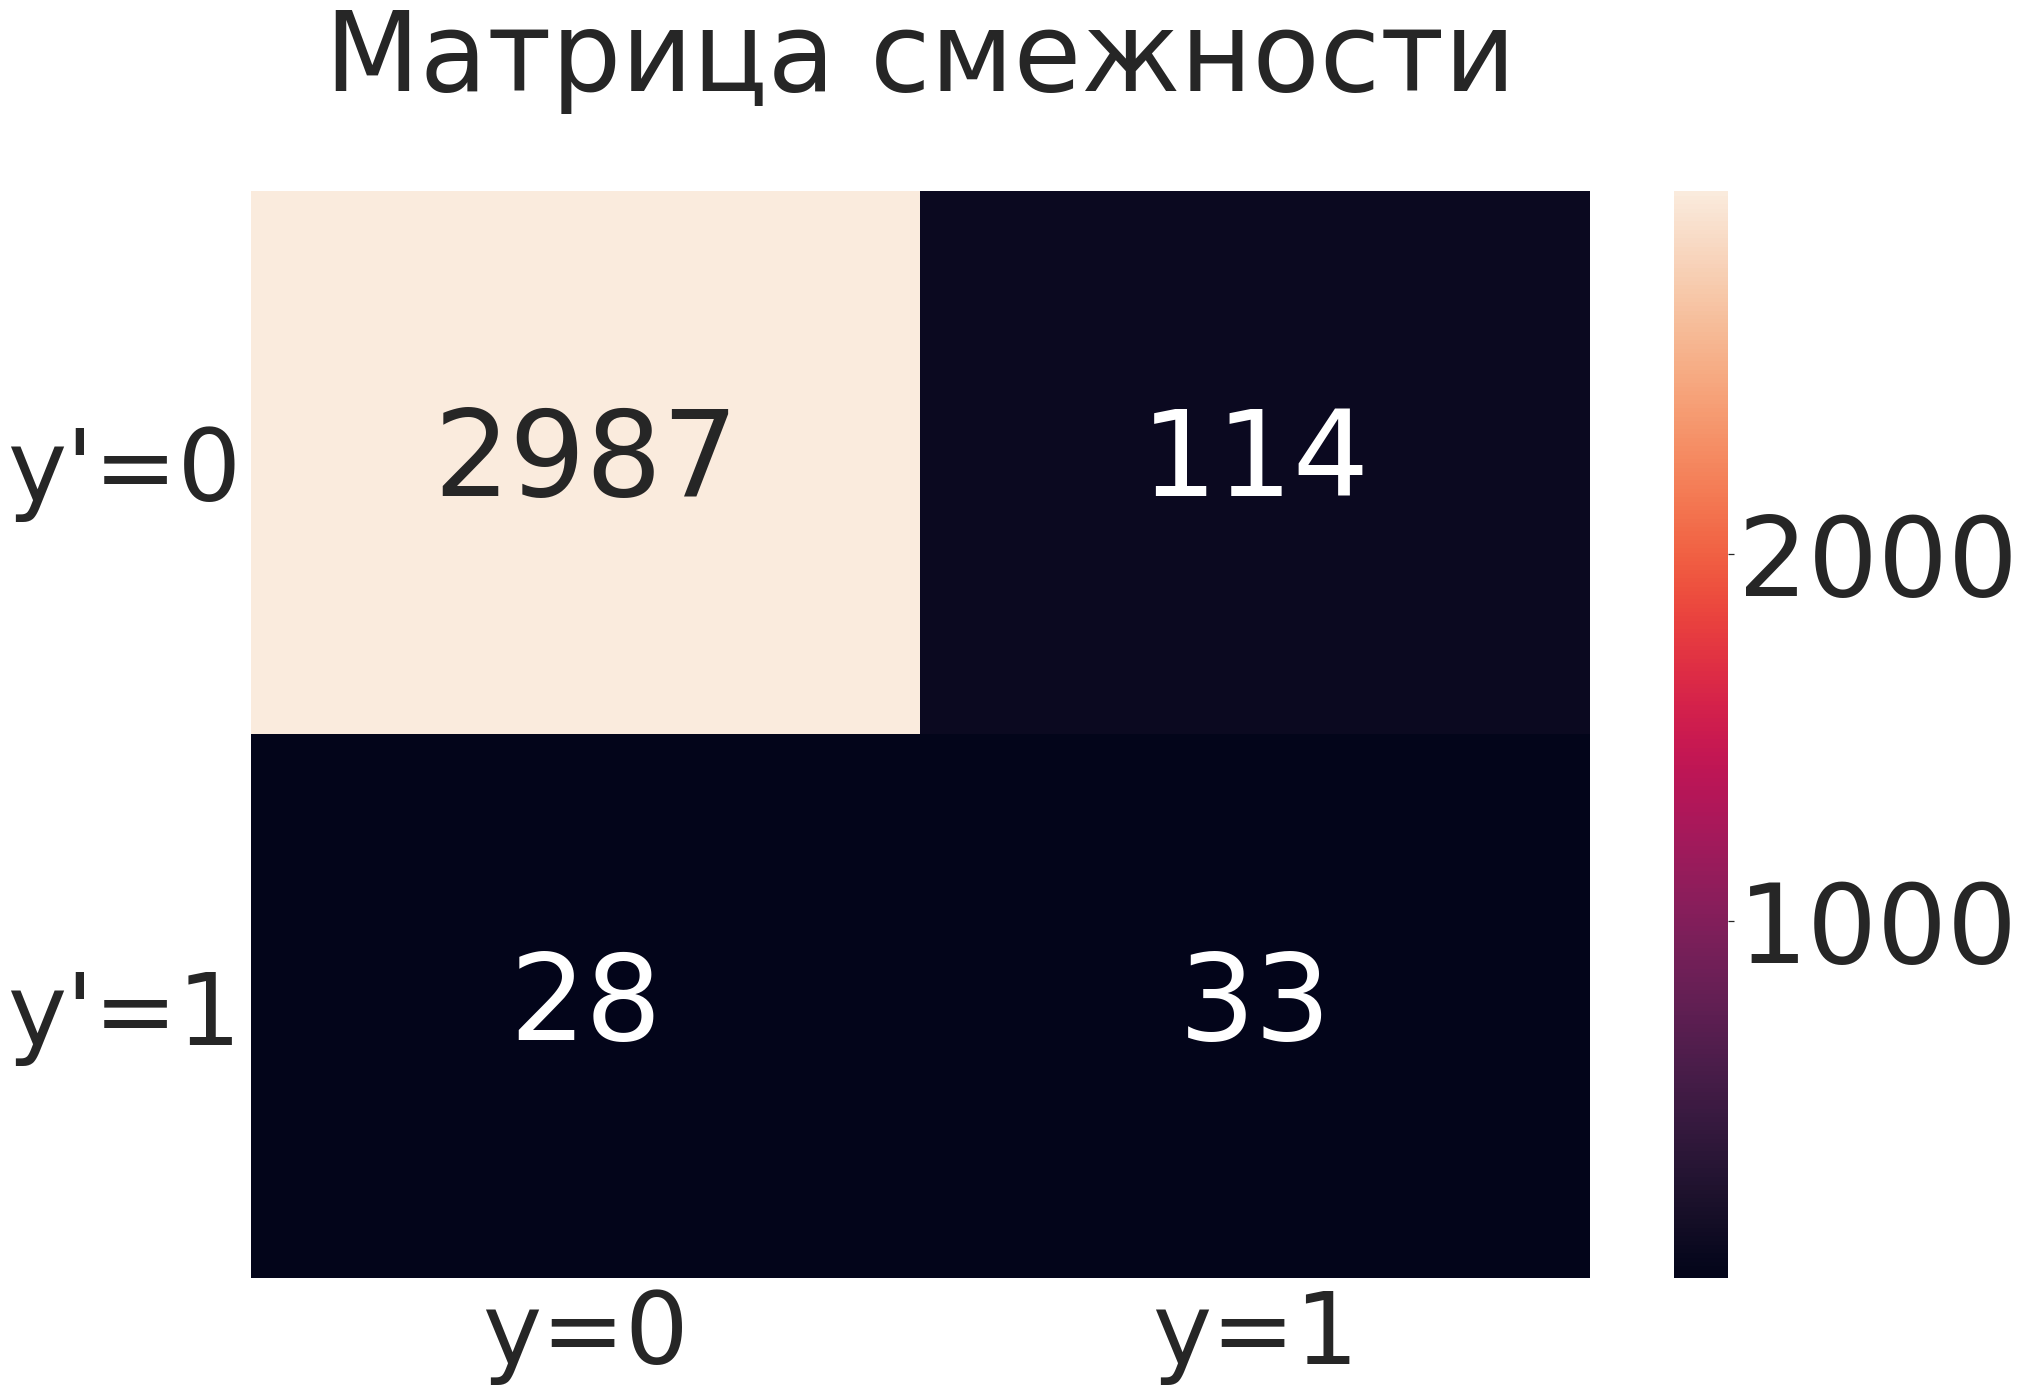

In [ ]:
evaluate(X_test,y_test,saved_model,'MlpKeras')

# Тест итоговой модели с шага по настройке dropout

In [ ]:
def metrics(y_test, ypred):
    recall = recall_score(y_test, ypred)
    precis = precision_score(y_test, ypred)
    f1 = f1_score(y_test, ypred)
    auroc = roc_auc_score(y_test, ypred)
    avg_precis = average_precision_score(y_test, ypred)
    print("Recall score: "+str(recall))
    print("Precision score: "+str(precis))
    print("F1 score: "+str(f1))
    print("AUROC: "+str(auroc))
    print("Average Precision score: "+str(avg_precis))

In [ ]:
def plot_confusion_matrix(y, predictions, type):
 mtrx = confusion_matrix(predictions, y);
 sns.set(font_scale=10)
 plt.figure(figsize=[30, 20])
 ax = sns.heatmap(mtrx, annot=True, fmt='d');
 ax.set_xticklabels(['y=0', 'y=1'], size='small')
 ax.set_yticklabels(["y'=0", "y'=1"], size='small')
 plt.yticks(rotation=0);

 plt.title(
 "Матрица смежности",
 pad=100,
 fontdict={'fontsize': 110}
 );

 plt.savefig(
 'conf-%s.png' % (type),
 bbox_inches='tight',
 transparent=True
 )

 plt.show();

In [ ]:
def evaluate(X, y, model, type):
 predictions = model.predict(X)
 predictions = (predictions>0.5)

 accuracy = accuracy_score(y, predictions)
 precision = precision_score(y, predictions)
 recall = recall_score(y, predictions)

 print('Test accuracy:', accuracy)
 print('Test precision:', precision)
 print('Test recall:', recall)

 plot_confusion_matrix(y, predictions, type)

In [ ]:
ypred = grid.predict(X_test)
metrics(y_test, ypred)

Recall score: 0.1836734693877551
Precision score: 0.5192307692307693
F1 score: 0.271356783919598
AUROC: 0.5876907977121196
Average Precision score: 0.13331958093411062


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test accuracy: 0.9541429475015812
Test precision: 0.5192307692307693
Test recall: 0.1836734693877551


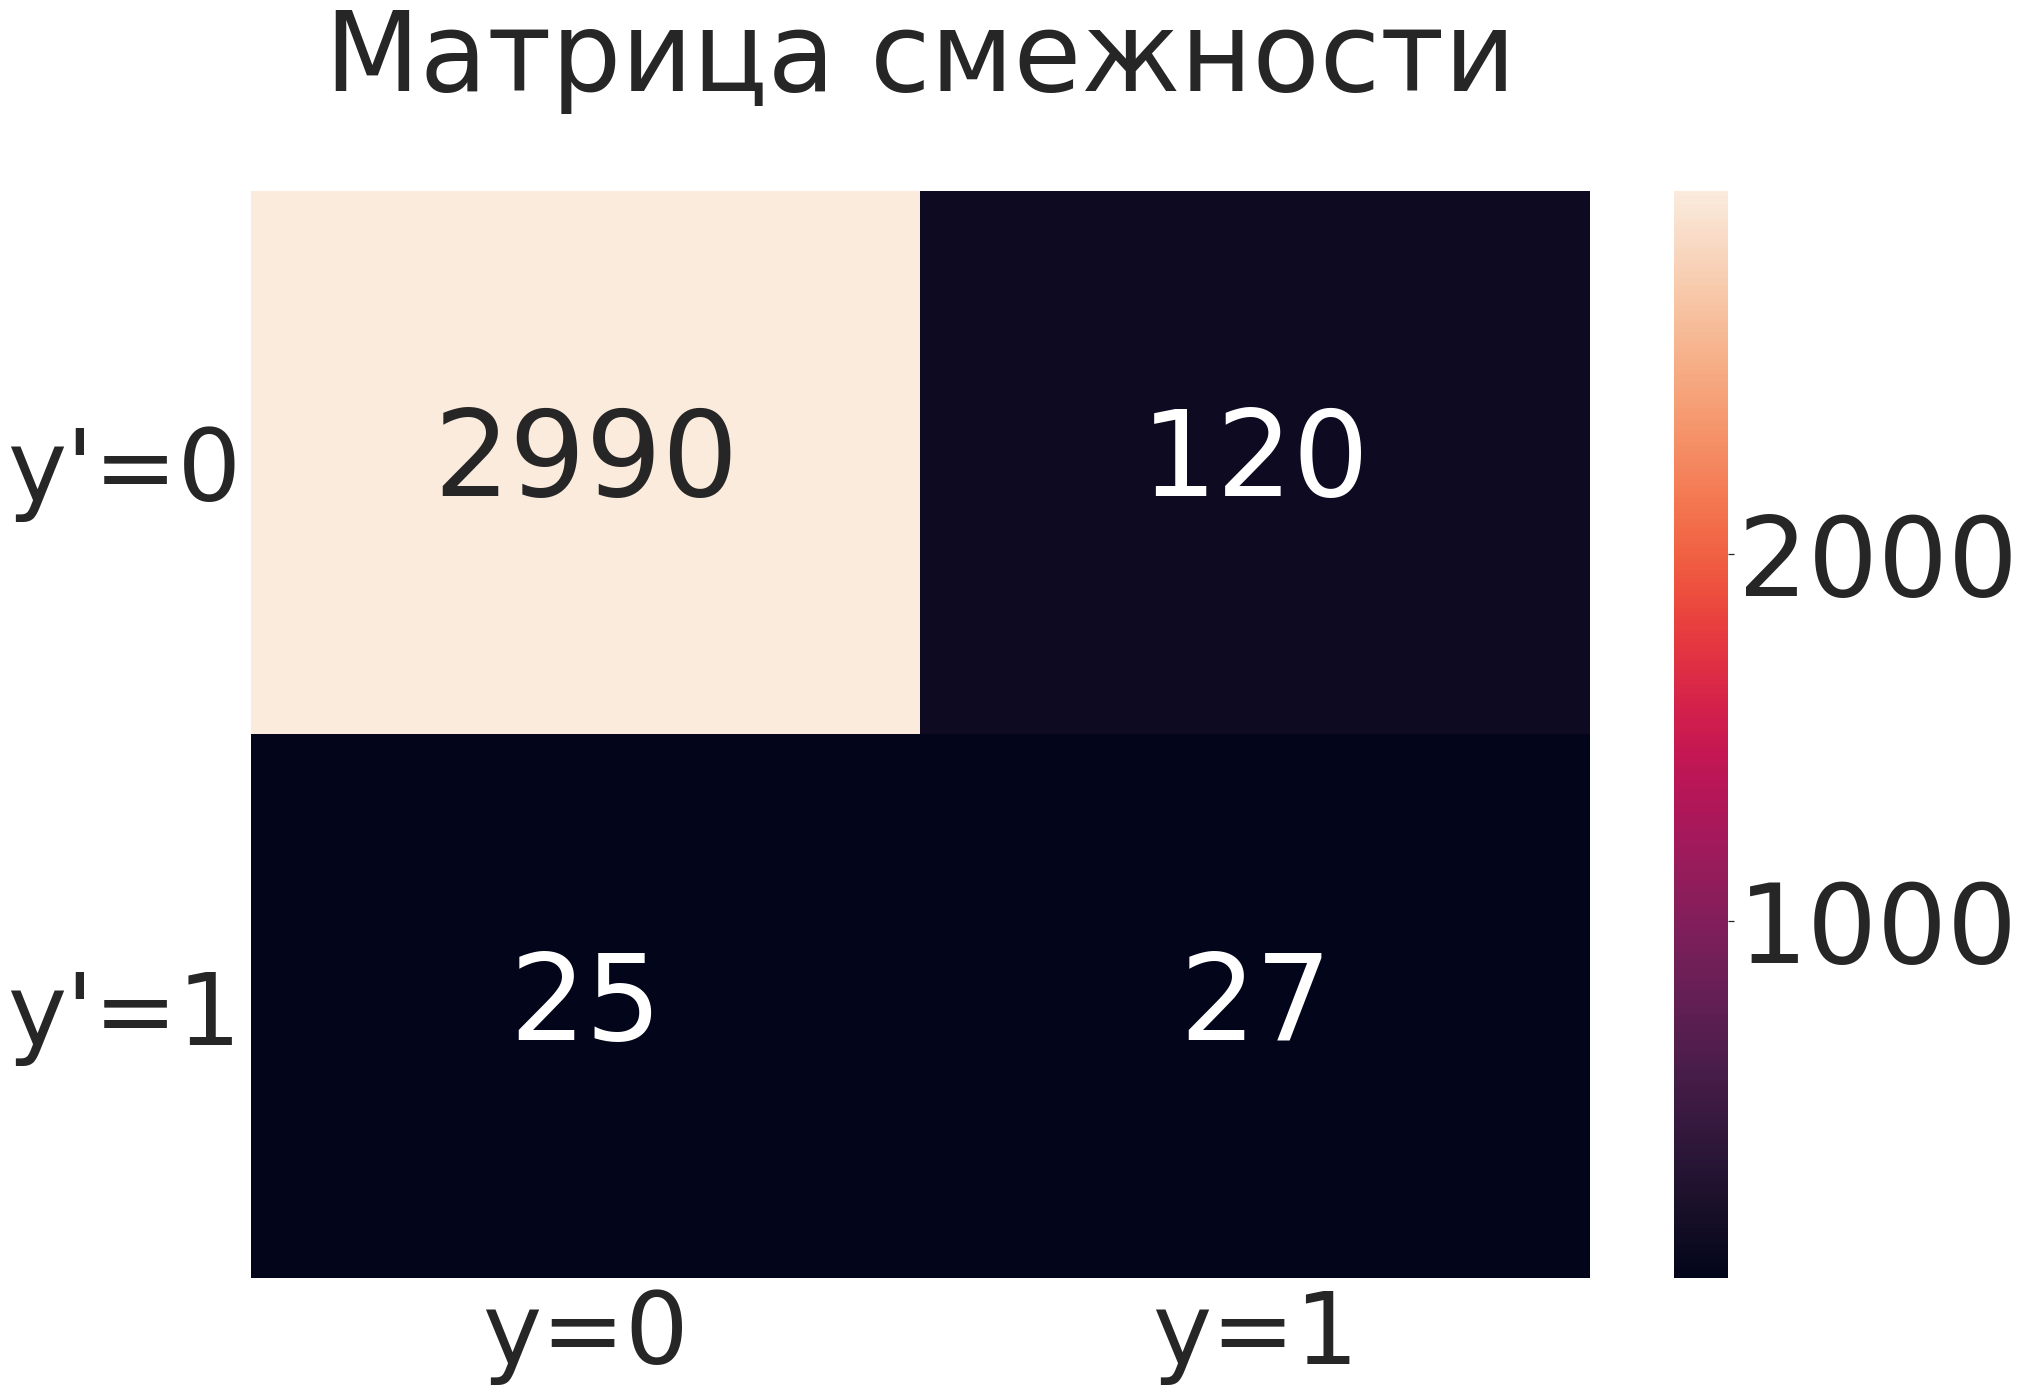

In [ ]:
evaluate(X_test,y_test,grid,'MlpKeras')

In [ ]:
perm = PermutationImportance(grid, random_state=1).fit(X_train,y_train)
eli5.show_weights(perm, feature_names = X.columns.tolist())

In [ ]:
ypred = grid.predict(X_test)
ypred

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

# Для roc_auc меры оптимизация нейронной сети

## Настраиваем количество эпох и батчей

In [ ]:
def create_model():


  model = Sequential()
  model.add(Dense(22, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), input_shape=(X_train.shape[1],), activation ='relu'))
  model.add(Dense(11, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), activation ='relu'))
  model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='sgd', metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy'])

  return model

X_train, X_test, y_train, y_test = Split_MinMax_Scalling(Set)

model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80]
epochs = [10, 50, 100]
param_grid = dict(model__batch_size=batch_size, model__epochs=epochs)
kf = KFold(n_splits=4, random_state=0, shuffle=True)
sampler = SMOTE(random_state=0, ratio=0.9)
estimator = Pipeline([("sampler", sampler), 
                       ("model", model)])

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=3, scoring = 'roc_auc')
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best: 0.707558 using {'model__batch_size': 80, 'model__epochs': 50}
0.704331 (0.026436) with: {'model__batch_size': 10, 'model__epochs': 10}
0.669318 (0.023660) with: {'model__batch_size': 10, 'model__epochs': 50}
0.644433 (0.022167) with: {'model__batch_size': 10, 'model__epochs': 100}
0.702598 (0.027748) with: {'model__batch_size': 20, 'model__epochs': 10}
0.705377 (0.026829) with: {'model__batch_size': 20, 'model__epochs': 50}
0.668788 (0.017287) with: {'model__batch_size': 20, 'model__epochs': 100}
0.692316 (0.022394) with: {'model__batch_size': 40, 'model__epochs': 10}
0.695855 (0.020410) with: {'model__batch_size': 40, 'model__epochs': 50}
0.691674 (0.025761) with: {'model__batch_size': 40, 'model__epochs': 100}
0.675778 (0.012185) with: {'model__batch_size': 60, 'model__epochs': 10}
0.706690 (0.036219) with: {'model__batch_size': 60, 'model__epochs': 50}
0.695365 (0.027659) with: {'model__batch_size': 60, 'model__epochs': 100}
0.664820 (0.033665) with: {'model__batch_size': 80, 

In [ ]:
def create_model(optimizer='adam'):


  model = Sequential()
  model.add(Dense(22, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), input_shape=(X_train.shape[1],), activation ='relu'))
  model.add(Dense(11, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), activation ='relu'))
  model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))

  model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy'])
  return model
X_train, X_test, y_train, y_test = Split_MinMax_Scalling(Set)

model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=80, verbose=0)

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(model__optimizer=optimizer)

kf = KFold(n_splits=4, random_state=0, shuffle=True)
sampler = SMOTE(random_state=0, ratio=0.9)
estimator = Pipeline([("sampler", sampler), 
                       ("model", model)])



# define the grid search parameters

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=kf, scoring= 'roc_auc')
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best: 0.698414 using {'model__optimizer': 'SGD'}
0.698414 (0.017729) with: {'model__optimizer': 'SGD'}
0.668610 (0.029918) with: {'model__optimizer': 'RMSprop'}
0.657294 (0.027440) with: {'model__optimizer': 'Adagrad'}
0.533508 (0.032625) with: {'model__optimizer': 'Adadelta'}
0.662867 (0.040541) with: {'model__optimizer': 'Adam'}
0.679856 (0.034112) with: {'model__optimizer': 'Adamax'}
0.659006 (0.050187) with: {'model__optimizer': 'Nadam'}


## Настраиваем параметры SGD

In [ ]:
from keras.optimizers import SGD

def create_model(learn_rate=0.01, momentum=0):
	# create model
  optimizer = SGD(lr=learn_rate, momentum=momentum)

  model = Sequential()
  model.add(Dense(22, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), input_shape=(X_train.shape[1],), activation ='relu'))
  model.add(Dense(11, kernel_initializer='glorot_uniform', bias_initializer=tf.keras.initializers.Constant(0.1), activation ='relu'))
  model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

X_train, X_test, y_train, y_test = Split_MinMax_Scalling(Set)


# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset

# create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=80, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.9]
param_grid = dict(model__learn_rate=learn_rate, model__momentum=momentum)


kf = KFold(n_splits=4, random_state=0, shuffle=True)
sampler = SMOTE(random_state=0, ratio=0.9)
estimator = Pipeline([("sampler", sampler), 
                       ("model", model)])

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=kf, scoring= 'roc_auc')
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best: 0.705240 using {'model__learn_rate': 0.01, 'model__momentum': 0.2}
0.644971 (0.027966) with: {'model__learn_rate': 0.001, 'model__momentum': 0.0}
0.666586 (0.038716) with: {'model__learn_rate': 0.001, 'model__momentum': 0.2}
0.647184 (0.012723) with: {'model__learn_rate': 0.001, 'model__momentum': 0.4}
0.669276 (0.008448) with: {'model__learn_rate': 0.001, 'model__momentum': 0.6}
0.703748 (0.025827) with: {'model__learn_rate': 0.001, 'model__momentum': 0.9}
0.704702 (0.016599) with: {'model__learn_rate': 0.01, 'model__momentum': 0.0}
0.705240 (0.018602) with: {'model__learn_rate': 0.01, 'model__momentum': 0.2}
0.704220 (0.018388) with: {'model__learn_rate': 0.01, 'model__momentum': 0.4}
0.695517 (0.020148) with: {'model__learn_rate': 0.01, 'model__momentum': 0.6}
0.661633 (0.019716) with: {'model__learn_rate': 0.01, 'model__momentum': 0.9}
0.668952 (0.045801) with: {'model__learn_rate': 0.1, 'model__momentum': 0.0}
0.671878 (0.026688) with: {'model__learn_rate': 0.1, 'model__mome

In [ ]:

def create_model(init_mode_sl='he_normal',init_mode_fl ='glorot_normal', activation= 'relu' ):
	# create model
  model = Sequential()
  model.add(Dense(22, input_shape=(X_train.shape[1],), kernel_initializer=init_mode_sl, activation=activation))
  model.add(Dense(11, kernel_initializer=init_mode_sl, activation=activation))
  model.add(Dense(1, kernel_initializer=init_mode_fl, activation='sigmoid'))
	# Compile model
  model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.01, momentum=0.2), metrics=['accuracy'])
  return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

X_train, X_test, y_train, y_test = Split_MinMax_Scalling(Set)

# create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=80, verbose=0)
# define the grid search parameters
init_mode_sl = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
init_mode_fl = ['glorot_normal','glorot_uniform']
activation = ['relu','tanh']

param_grid = dict(model__init_mode_sl=init_mode_sl, model__init_mode_fl=init_mode_fl, model__activation=activation)

kf = KFold(n_splits=4, random_state=0, shuffle=True) 
sampler = SMOTE(random_state=0, ratio=0.9) 
estimator = Pipeline([("sampler", sampler), 
                       ("model", model)])

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=kf, scoring= 'roc_auc')
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best: 0.709270 using {'model__activation': 'relu', 'model__init_mode_fl': 'glorot_uniform', 'model__init_mode_sl': 'glorot_uniform'}
0.702459 (0.014779) with: {'model__activation': 'relu', 'model__init_mode_fl': 'glorot_normal', 'model__init_mode_sl': 'uniform'}
0.701497 (0.022282) with: {'model__activation': 'relu', 'model__init_mode_fl': 'glorot_normal', 'model__init_mode_sl': 'lecun_uniform'}
0.692419 (0.015264) with: {'model__activation': 'relu', 'model__init_mode_fl': 'glorot_normal', 'model__init_mode_sl': 'normal'}
0.500000 (0.000000) with: {'model__activation': 'relu', 'model__init_mode_fl': 'glorot_normal', 'model__init_mode_sl': 'zero'}
0.702871 (0.022226) with: {'model__activation': 'relu', 'model__init_mode_fl': 'glorot_normal', 'model__init_mode_sl': 'glorot_normal'}
0.704650 (0.018027) with: {'model__activation': 'relu', 'model__init_mode_fl': 'glorot_normal', 'model__init_mode_sl': 'glorot_uniform'}
0.707392 (0.015771) with: {'model__activation': 'relu', 'model__init_mod

In [ ]:

from keras.constraints import maxnorm

def create_model(dropout_rate_1=0.1, dropout_rate_2=0.1):
	# create model
  model = Sequential()
  model.add(Dense(22, input_shape=(X_train.shape[1],), kernel_initializer='glorot_uniform', activation='relu', kernel_constraint=maxnorm(3)))
  model.add(Dropout(dropout_rate_1))
  model.add(Dense(11, kernel_initializer='glorot_uniform', activation='relu', kernel_constraint=maxnorm(3)))
  model.add(Dropout(dropout_rate_2))
  model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))
	# Compile model
  model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.01, momentum=0.2), metrics=['accuracy'])
  return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)


# create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=80, verbose=0)
# define the grid search parameters
dropout_rate_1 = [ 0.1, 0.3, 0.5]
dropout_rate_2 = [ 0,0.1,0.2,0.3,0.4,0.5]


param_grid = dict(model__dropout_rate_1=dropout_rate_1,model__dropout_rate_2=dropout_rate_2)

kf = KFold(n_splits=4, random_state=0, shuffle=True)
sampler = SMOTE(random_state=0, ratio=0.9)
estimator = Pipeline([("sampler", sampler), 
                       ("model", model)])

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=kf, scoring= 'roc_auc')
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: nan using {'model__dropout_rate_1': 0.1, 'model__dropout_rate_2': 0}
nan (nan) with: {'model__dropout_rate_1': 0.1, 'model__dropout_rate_2': 0}
nan (nan) with: {'model__dropout_rate_1': 0.1, 'model__dropout_rate_2': 0.1}
nan (nan) with: {'model__dropout_rate_1': 0.1, 'model__dropout_rate_2': 0.2}
nan (nan) with: {'model__dropout_rate_1': 0.1, 'model__dropout_rate_2': 0.3}
nan (nan) with: {'model__dropout_rate_1': 0.1, 'model__dropout_rate_2': 0.4}
nan (nan) with: {'model__dropout_rate_1': 0.1, 'model__dropout_rate_2': 0.5}
nan (nan) with: {'model__dropout_rate_1': 0.3, 'model__dropout_rate_2': 0}
nan (nan) with: {'model__dropout_rate_1': 0.3, 'model__dropout_rate_2': 0.1}
nan (nan) with: {'model__dropout_rate_1': 0.3, 'model__dropout_rate_2': 0.2}
nan (nan) with: {'model__dropout_rate_1': 0.3, 'model__dropout_rate_2': 0.3}
nan (nan) with: {'model__dropout_rate_1': 0.3, 'model__dropout_rate_2': 0.4}
nan (nan) with: {'model__dropout_rate_1': 0.3, 'model__dropout_rate_2': 0.5}
nan (

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test accuracy: 0.775774826059456
Test precision: 0.11716621253405994
Test recall: 0.5850340136054422


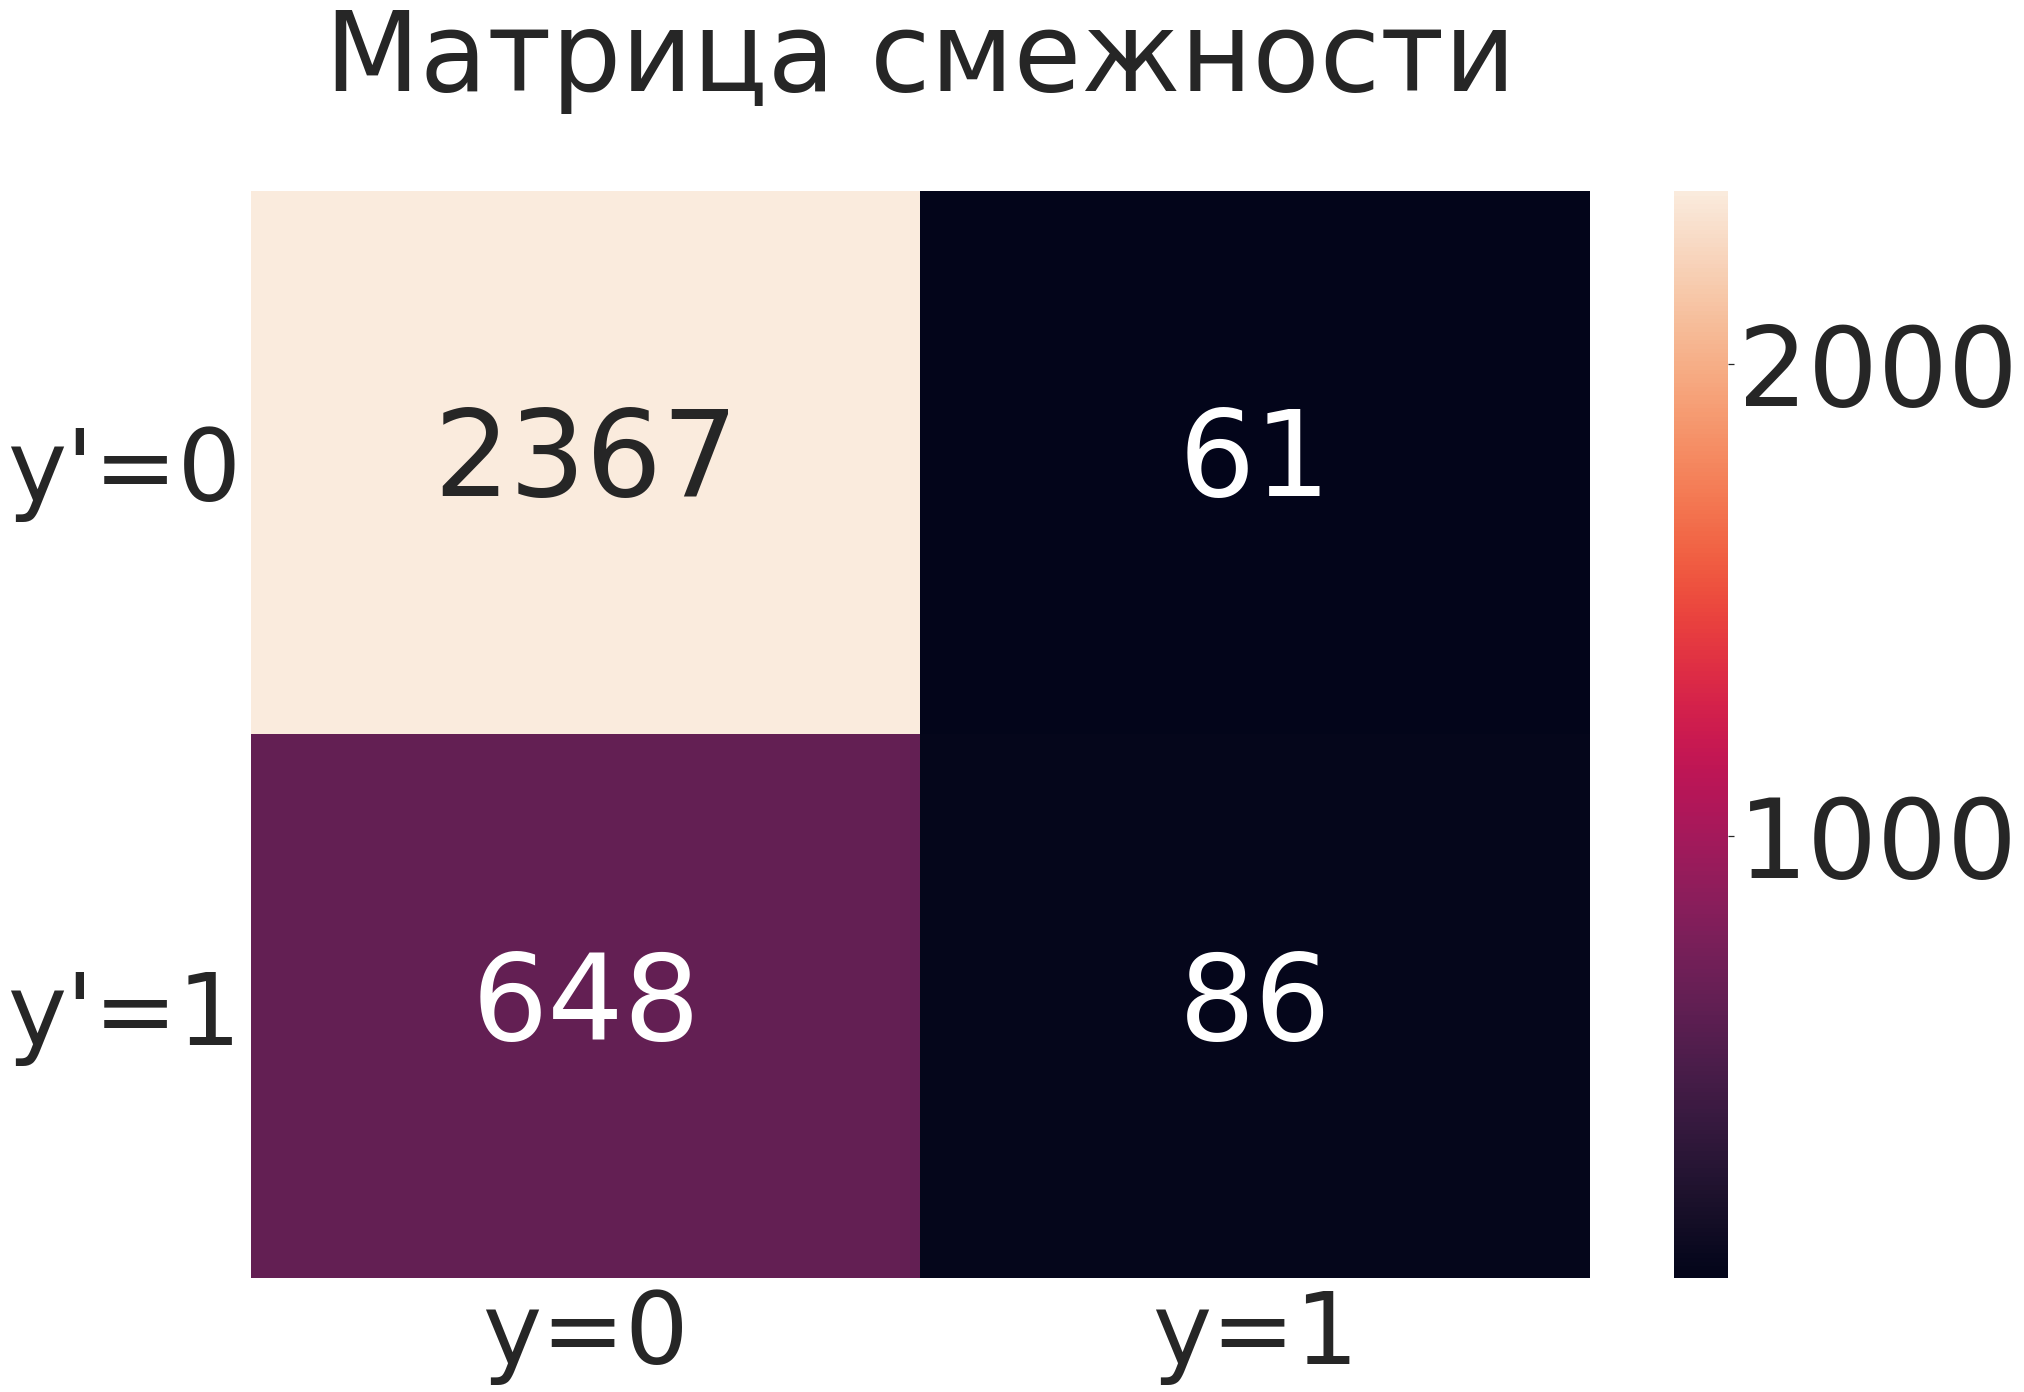

In [ ]:
evaluate(X_test,y_test,grid,'MlpKeras')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test accuracy: 0.7795698924731183
Test precision: 0.11048158640226628
Test recall: 0.5306122448979592


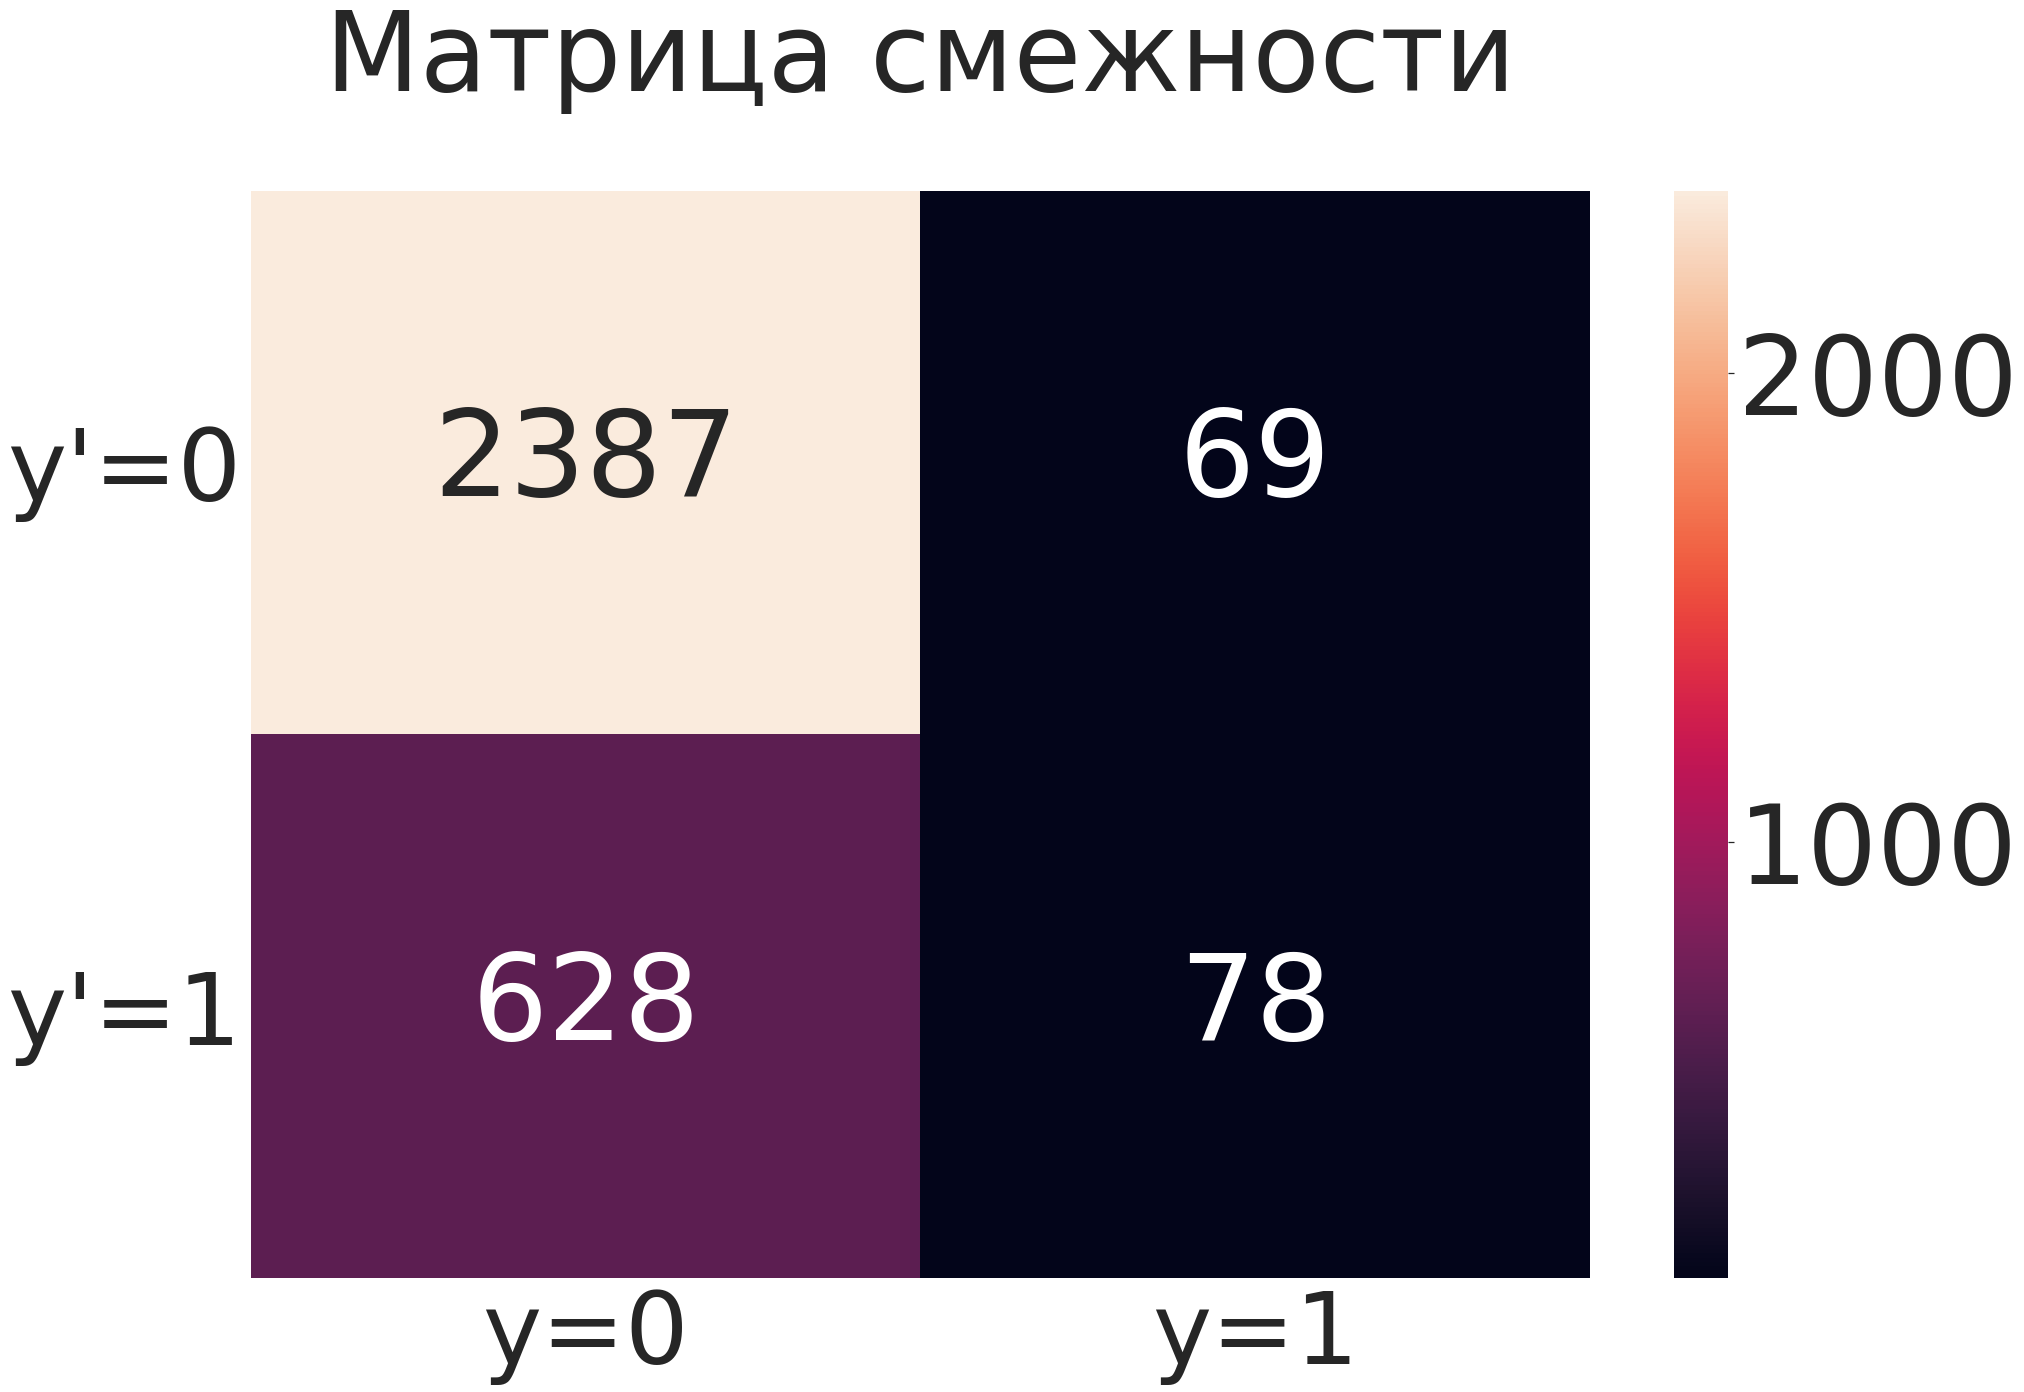

In [ ]:
evaluate(X_test,y_test,grid,'MlpKeras')

# Итоговая архитектура roc_auc

In [ ]:
def create_model2():
  model = Sequential()
  model.add(Dense(22, input_shape=(X_train.shape[1],), kernel_initializer='glorot_uniform', activation='relu', kernel_constraint=maxnorm(3)))
  model.add(Dropout(0.1))
  model.add(Dense(11, kernel_initializer='glorot_uniform', activation='relu', kernel_constraint=maxnorm(3)))
  model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))
	# Compile model
  model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.01, momentum=0.2), metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy',tf.keras.metrics.SpecificityAtSensitivity(0.99),tf.keras.metrics.AUC(
     curve='ROC'
)])
  return model

model = KerasClassifier(build_fn=create_model, epochs=200, batch_size=80, verbose=0)


In [ ]:
import h5py
from keras.callbacks import EarlyStopping, ModelCheckpoint
#Получаем данные
X_train, X_test, y_train, y_test = Split_MinMax_Scalling(Set)
#Находми нужные веса, для ПР будут большими, для СР малыми
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)

#Применяем ADASYN
X_train,y_train = Do_SMOTE(X_train, y_train, 0.9)

#Вызываем нс
modelfinal = create_model2()
#применяем раннюю остановку  Не забудь менять номер метрики! всрато конечно
#es = EarlyStopping(monitor='val_specificity_at_sensitivity_23', mode='max', verbose=1, patience=20)
#Применение сохранения лучшей модели
mc = ModelCheckpoint('best_modelFinalROC.h5', monitor='val_specificity_at_sensitivity_15', mode='max', save_best_only=True, verbose=1)
modelfinal.fit(X_train,y_train, batch_size=80,epochs=200,verbose=0,validation_data=(X_test,y_test), callbacks=[mc])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)



Epoch 00001: val_specificity_at_sensitivity_15 improved from -inf to 0.54229, saving model to best_modelFinalROC.h5

Epoch 00002: val_specificity_at_sensitivity_15 improved from 0.54229 to 0.59337, saving model to best_modelFinalROC.h5

Epoch 00003: val_specificity_at_sensitivity_15 improved from 0.59337 to 0.64643, saving model to best_modelFinalROC.h5

Epoch 00004: val_specificity_at_sensitivity_15 improved from 0.64643 to 0.66269, saving model to best_modelFinalROC.h5

Epoch 00005: val_specificity_at_sensitivity_15 improved from 0.66269 to 0.70746, saving model to best_modelFinalROC.h5

Epoch 00006: val_specificity_at_sensitivity_15 improved from 0.70746 to 0.72272, saving model to best_modelFinalROC.h5

Epoch 00007: val_specificity_at_sensitivity_15 improved from 0.72272 to 0.72570, saving model to best_modelFinalROC.h5

Epoch 00008: val_specificity_at_sensitivity_15 improved from 0.72570 to 0.73433, saving model to best_modelFinalROC.h5

Epoch 00009: val_specificity_at_sensitivit

In [ ]:
from keras.models import load_model
saved_model3 = load_model('best_modelFinalROC.h5')

Test accuracy: 0.8703352308665402
Test precision: 0.1636828644501279
Test recall: 0.43537414965986393


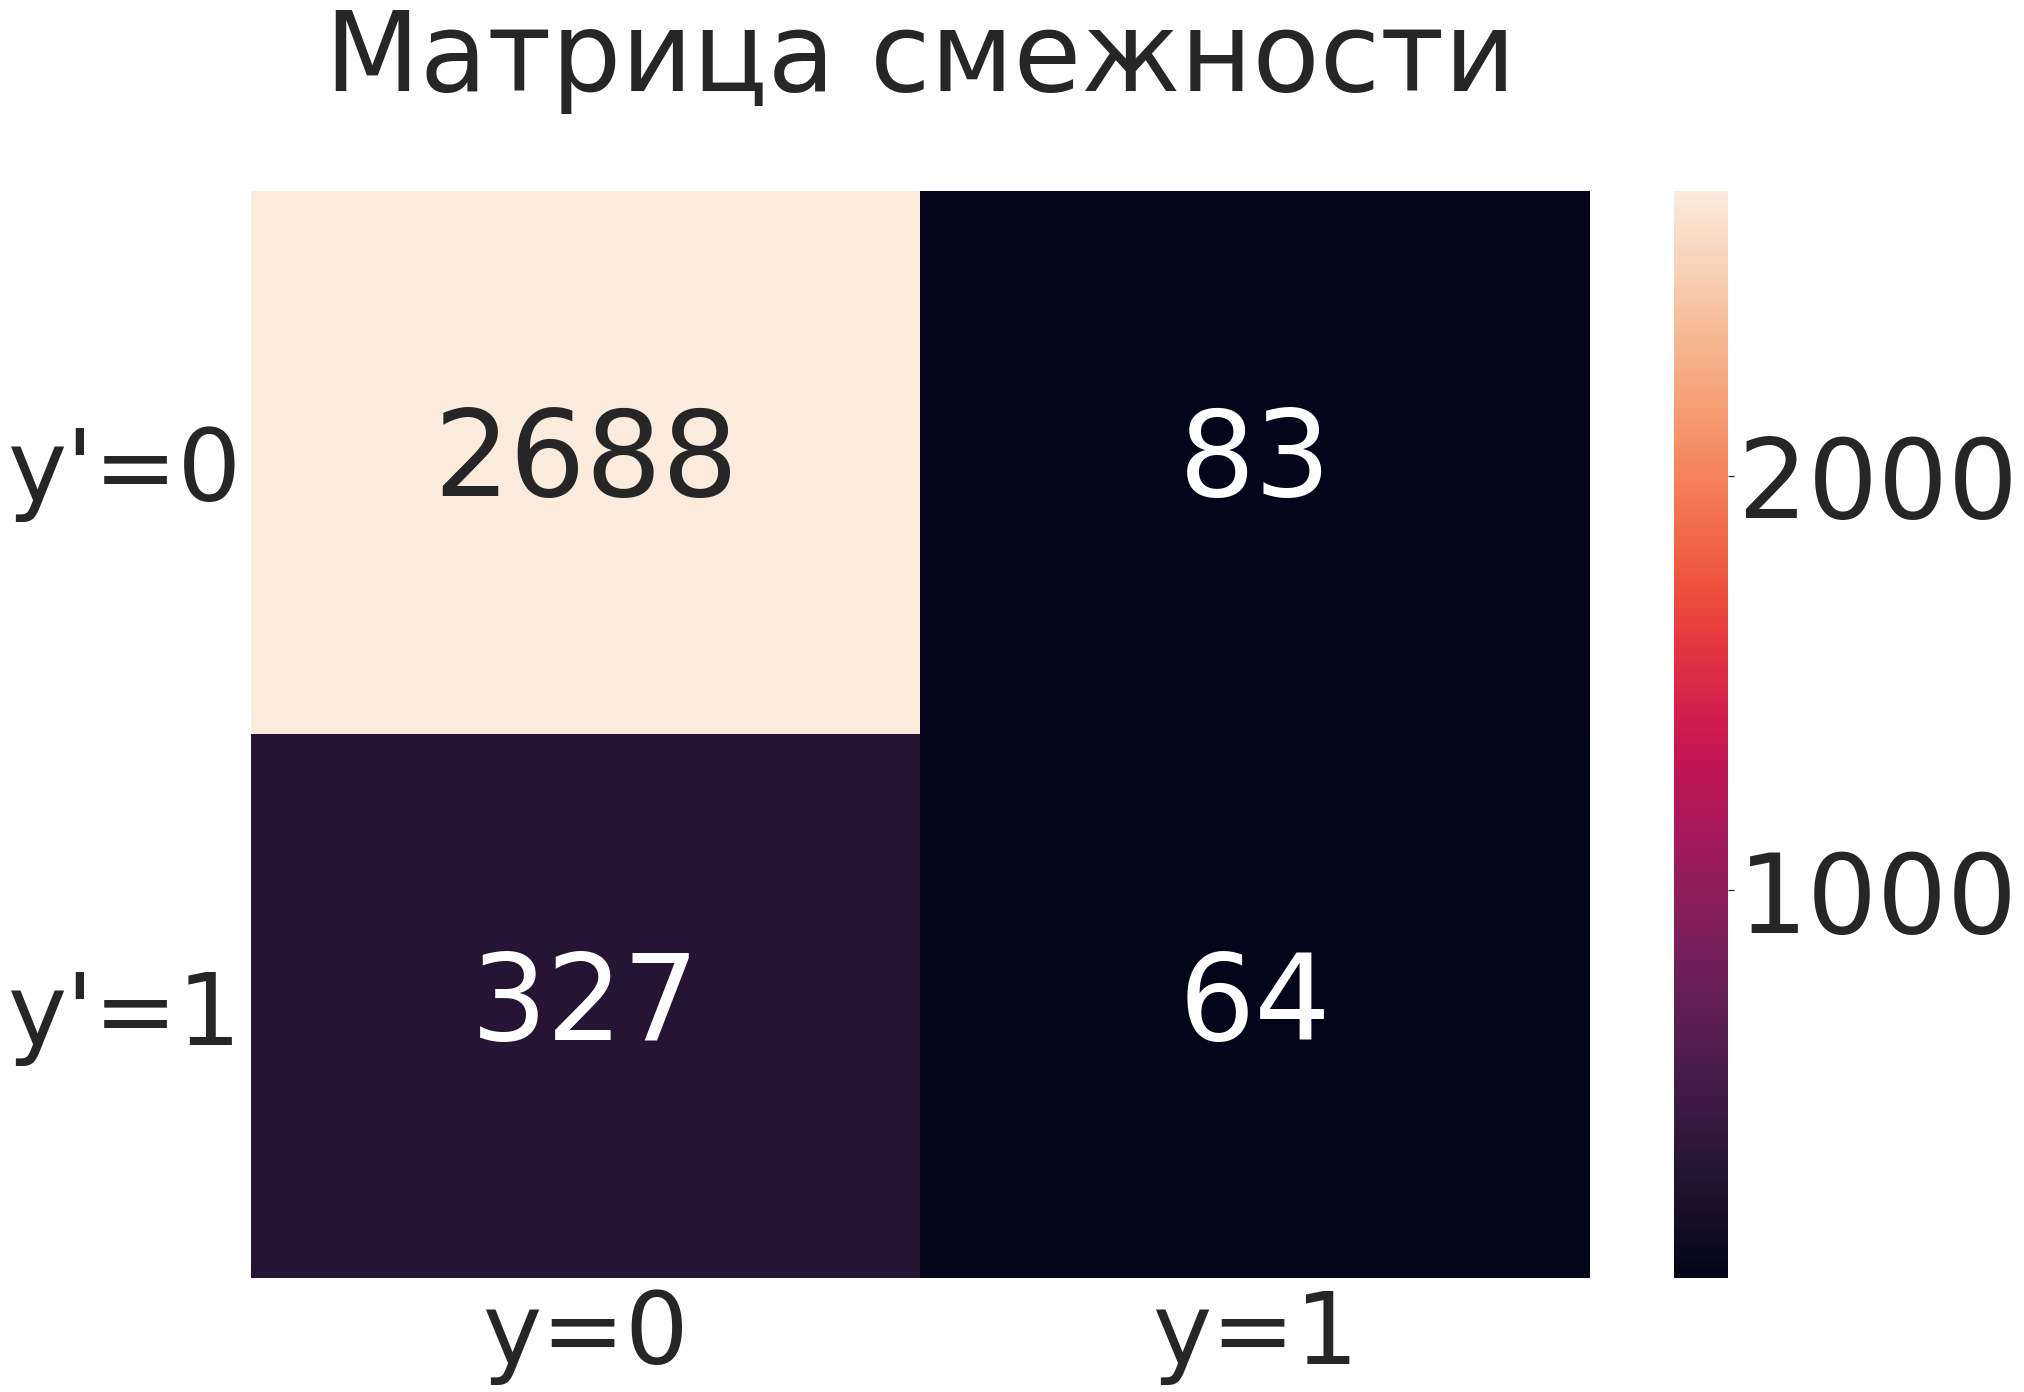

In [ ]:
saved_model3 = load_model('best_modelFinalROC.h5')
evaluate(X_test,y_test,saved_model3,'MlpKeras')

In [ ]:
import h5py
from keras.callbacks import EarlyStopping, ModelCheckpoint
#Получаем данные
X_train, X_test, y_train, y_test = Split_MinMax_Scalling(Set)
#Находми нужные веса, для ПР будут большими, для СР малыми
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)

#Применяем ADASYN
X_train,y_train = Do_SMOTE(X_train, y_train, 0.9)

#Вызываем нс
modelfinal = create_model2()
#применяем раннюю остановку  Не забудь менять номер метрики! всрато конечно
#es = EarlyStopping(monitor='val_specificity_at_sensitivity_23', mode='max', verbose=1, patience=20)
#Применение сохранения лучшей модели
mc = ModelCheckpoint('best_modelFinalROC3.h5', monitor='val_auc_1', mode='max', save_best_only=True, verbose=1)
modelfinal.fit(X_train,y_train, batch_size=80,epochs=200,verbose=0,validation_data=(X_test,y_test), callbacks=[mc])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)



Epoch 00001: val_auc_1 improved from -inf to 0.50387, saving model to best_modelFinalROC3.h5

Epoch 00002: val_auc_1 improved from 0.50387 to 0.58244, saving model to best_modelFinalROC3.h5

Epoch 00003: val_auc_1 improved from 0.58244 to 0.62651, saving model to best_modelFinalROC3.h5

Epoch 00004: val_auc_1 improved from 0.62651 to 0.65285, saving model to best_modelFinalROC3.h5

Epoch 00005: val_auc_1 improved from 0.65285 to 0.67250, saving model to best_modelFinalROC3.h5

Epoch 00006: val_auc_1 improved from 0.67250 to 0.69700, saving model to best_modelFinalROC3.h5

Epoch 00007: val_auc_1 improved from 0.69700 to 0.70155, saving model to best_modelFinalROC3.h5

Epoch 00008: val_auc_1 improved from 0.70155 to 0.70775, saving model to best_modelFinalROC3.h5

Epoch 00009: val_auc_1 improved from 0.70775 to 0.71007, saving model to best_modelFinalROC3.h5

Epoch 00010: val_auc_1 improved from 0.71007 to 0.71422, saving model to best_modelFinalROC3.h5

Epoch 00011: val_auc_1 improved 

In [ ]:
list(modelfinal.history.history.keys())

['loss',
 'precision_22',
 'recall_22',
 'accuracy',
 'specificity_at_sensitivity_20',
 'val_loss',
 'val_precision_22',
 'val_recall_22',
 'val_accuracy',
 'val_specificity_at_sensitivity_20']

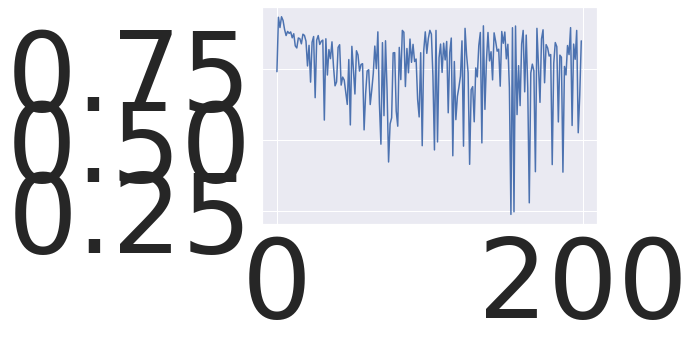

In [ ]:
#plt.title('Модель c оптимальными гиперпараметрами')
# plt.xlabel("Номер эпохи")
# plt.ylabel("")
# plt.plot(modelfinal.history.history[list(modelfinal.history.history.keys())[6]], label =list(modelfinal.history.history.keys())[6] , )
# plt.plot(modelfinal.history.history[list(modelfinal.history.history.keys())[8]], label =list(modelfinal.history.history.keys())[8] )
# plt.plot(modelfinal.history.history[list(modelfinal.history.history.keys())[7]], label =list(modelfinal.history.history.keys())[7] )
plt.plot(modelfinal.history.history[list(modelfinal.history.history.keys())[9]], label =list(modelfinal.history.history.keys())[10] , )

#plt.plot(Glorot_model_n.history.history[list(Glorot_model_n.history.history.keys())[7]], label =list(Glorot_model_n.history.history.keys())[7] )
#plt.plot(uniform_model.history.history['val_accuracy'], label ='Случайная иницилизация')
# plt.legend()


In [ ]:
!ls

best_modelFinal2.h5  best_modelFinalROC.h5  conf-MLP.png	sample_data
best_modelFinal.h5   conf-MlpKeras.png	    ModifyFinData.xlsx


Test accuracy: 0.50853889943074
Test precision: 0.07077486272117145
Test recall: 0.7891156462585034


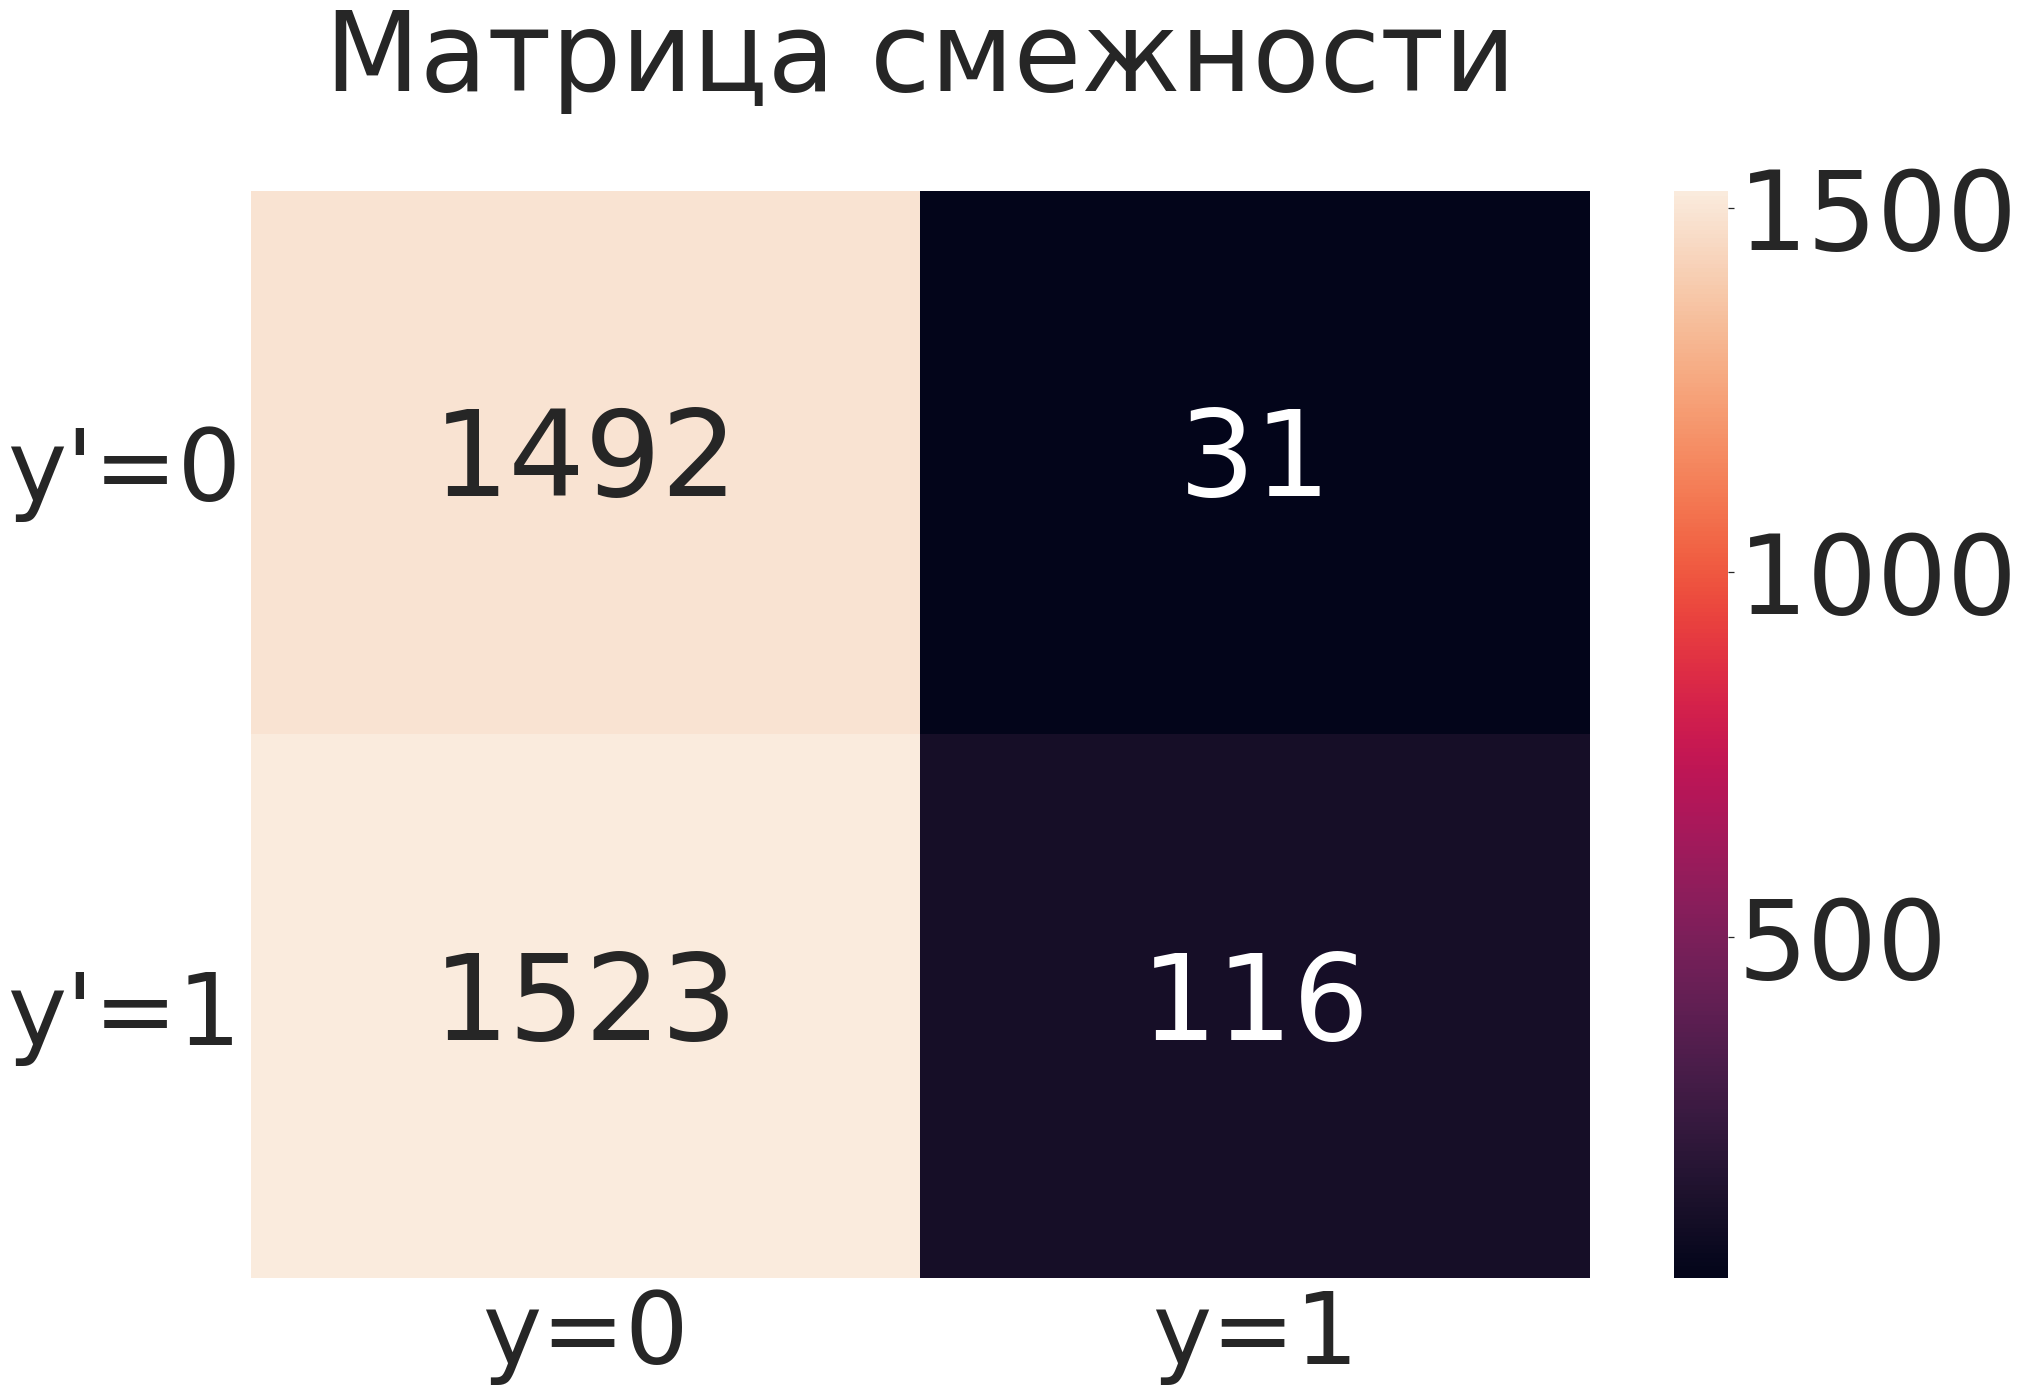

In [ ]:
saved_model3 = load_model('best_modelFinalROC.h5')
evaluate(X_test,y_test,saved_model3,'MlpKeras')

Test accuracy: 0.7893738140417458
Test precision: 0.12116788321167883
Test recall: 0.564625850340136


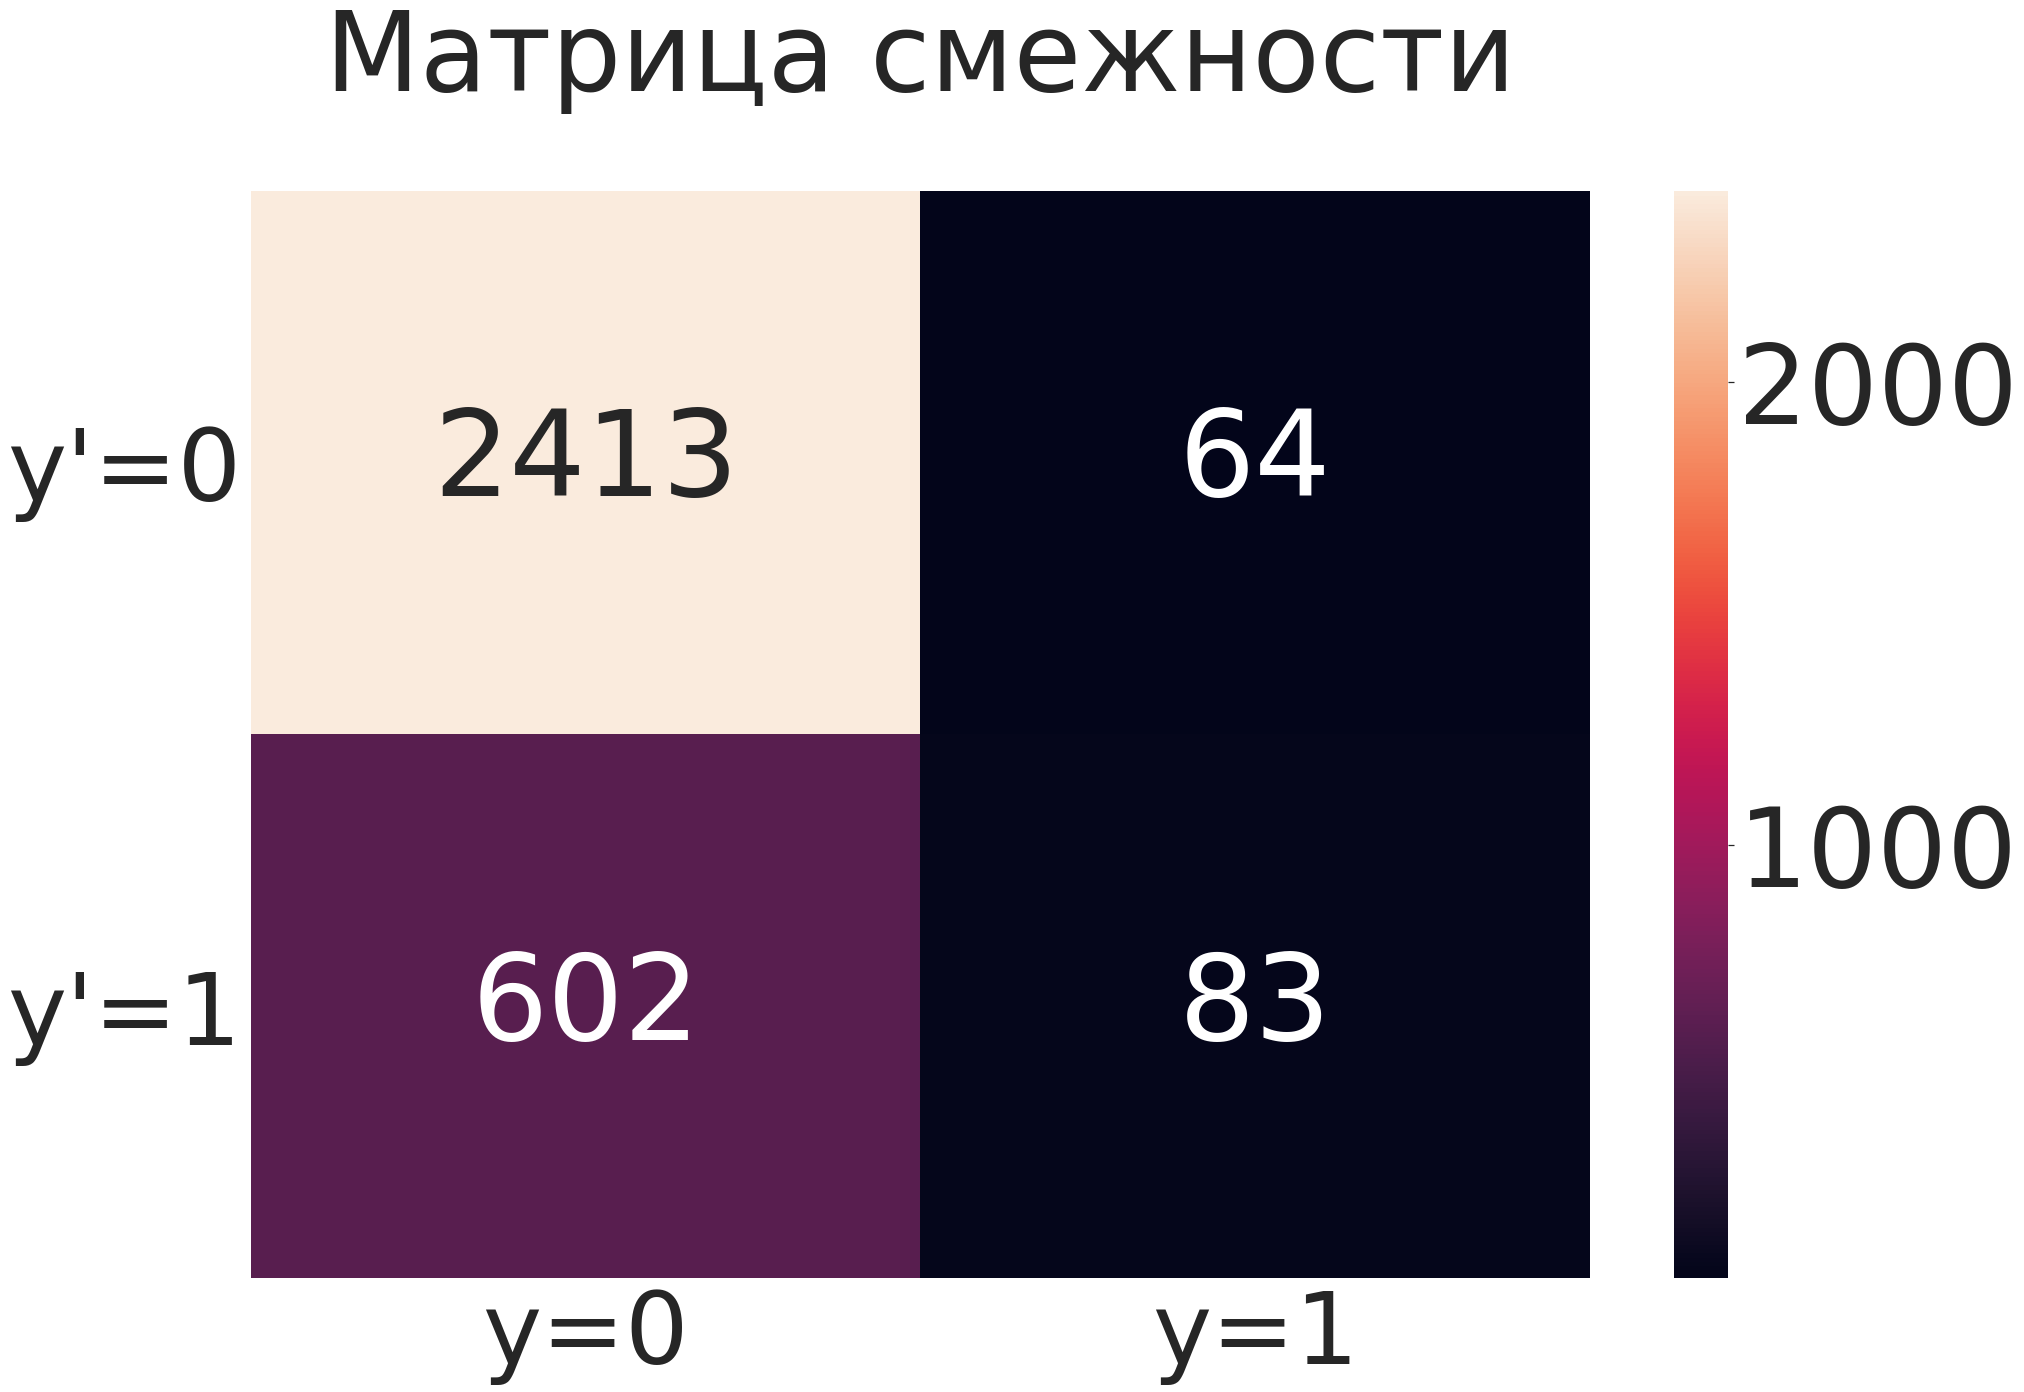

In [ ]:
saved_model3 = load_model('best_modelFinalROC3.h5')
evaluate(X_test,y_test,saved_model3,'MlpKeras')

In [ ]:
perm = PermutationImportance(saved_model3, random_state=1).fit(X_train,y_train)
eli5.show_weights(perm, feature_names = X.columns.tolist())

In [ ]:
(np.unique(dfm['СР']), )

TypeError: ignored

# Вывод значимости парамтеров

In [ ]:
X=Set.drop('Исход', axis=1)
X

,Возраст,Срок гестации,Вес,Рост,ЧСС,КТР,ТВП,Длина шейки матки,FBHCG MoM,PAPP-A MoM,Паритет,"Выкидыши, аборты, ЗБ",Количество плодов,Этническая принадлежность_Белая,Этническая принадлежность_Восточная Азия,Этническая принадлежность_Другая,Этническая принадлежность_Негроидная раса,Этническая принадлежность_Южная Азия,ИЦН_,ИЦН_Да,ИЦН_да,ИЦН_не определенно,ПР 16-30_0.0,ПР 16-30_1.0,ПР 16-30_2.0,ПР 16-30_3.0,ПР 16-30_4.0,ПР 16-30_не определенно,ПР 31-36_0.0,ПР 31-36_1.0,ПР 31-36_2.0,ПР 31-36_3.0,ПР 31-36_4.0,ПР 31-36_не определенно,СР_0.0,СР_1.0,СР_2.0,СР_3.0,СР_4.0,СР_5.0,СР_6.0,СР_7.0,СР_8.0,СР_15.0,СР_не определенно,Курение_НД,Курение_да,Курение_да,Курение_нет,Курение_прекратила,СД_Тип 1,СД_Тип 2,СД_не определенно,СД_нет,АГ_да,АГ_не определенно,АГ_нет,АФС_да,АФС_не определенно,АФС_нет,ПЭ_Да,ПЭ_НД,ПЭ_да,ПЭ_не определенно,ПЭ_нет,Зачатие_Инъекция сперматозоида в цитоплазму яйцеклетки (ICSI),Зачатие_Перенос гамет в маточные трубы (GIFT),Зачатие_ЭКО,Зачатие_естественное,Зачатие_инсеминация,Зачатие_стимуляция овуляции без ЭКО,Хориальность_дихориальная,Хориальность_дихориальная,Хориальность_монохориальная диамниотическая,Хориальность_монохориальная моноамниотическая,Хориальность_неизвестная хориальность,Хориальность_нет
0,38.0,11.571428,57.0,164.377593,161.0,48.3,1.60,38.109823,0.986,1.874,1,0,2,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
1,33.0,12.285714,67.0,160.000000,165.0,57.7,1.60,38.109823,0.370,0.919,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
2,34.0,12.142857,67.8,158.000000,156.0,55.5,1.67,38.109823,1.567,1.214,2,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
3,38.6,12.714285,76.0,168.000000,163.0,63.3,1.80,38.109823,1.348,1.076,2,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
4,34.0,12.714285,63.3,176.000000,158.0,64.0,1.34,46.000000,1.556,1.542,2,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12704,21.2,12.285714,67.3,163.000000,158.0,57.0,1.40,38.109823,1.023,2.410,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
12705,31.1,12.571429,46.0,160.000000,164.0,62.0,1.60,38.109823,2.326,0.789,2,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
12706,24.7,12.285714,65.0,162.000000,146.0,57.0,1.48,38.109823,0.419,0.401,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
12707,26.3,12.714286,56.6,170.000000,153.0,63.6,1.40,38.109823,0.862,0.390,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1


In [ ]:


# create model
model = KerasClassifier(build_fn=create_model2, epochs=40, batch_size=80, verbose=0)
# define the grid search parameters



param_grid = dict()

kf = KFold(n_splits=4, random_state=0, shuffle=True)
sampler = SMOTE(random_state=0, ratio=0.9)
estimator = Pipeline([("sampler", sampler), 
                       ("model", model)])

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=kf, scoring= 'roc_auc')
grid_result = grid.fit(X_train, y_train)
# summarize results
perm = PermutationImportance(grid_result, random_state=1).fit(X_train,y_train)
eli5.show_weights(perm, feature_names = X.columns.tolist())

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 202

Weight,Feature
0.0460 ± 0.0053,СД_не определенно
0.0327 ± 0.0031,АФС_нет
0.0301 ± 0.0040,СР_0.0
0.0291 ± 0.0025,АГ_не определенно
0.0258 ± 0.0040,Курение_нет
0.0215 ± 0.0034,Количество плодов
0.0180 ± 0.0031,ПЭ_не определенно
0.0142 ± 0.0032,Возраст
0.0127 ± 0.0016,PAPP-A MoM
0.0121 ± 0.0023,Рост


In [ ]:
!ls

best_modelFinal2.h5	best_modelFinalROC.h5  ModifyFinData.xlsx
best_modelFinal.h5	conf-MlpKeras.png      sample_data
best_modelFinalROC3.h5	conf-MLP.png


In [ ]:
files.download("best_modelFinalROC3.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [151]:
y=Set['Исход']

In [14]:
plt.rc('axes', labelsize=20)     # размер текста xlabel и ylabel
plt.rc('xtick', labelsize=20)    # размер меток по оси x
plt.rc('ytick', labelsize=20)    # размер меток по оси y
plt.rc('font', size=20)          # размер текста на графике    

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


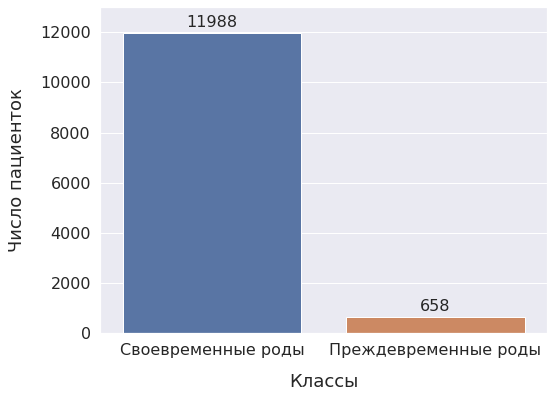

In [153]:
fig = plt.figure(figsize=(8, 6))
# vals = np.unique(y.values) # можешь закоментить эту строку, откоментить следующую и написать кастомные метки по x  
vals = ['Своевременные роды', 'Преждевременные роды'] 
height = y.value_counts()
ax = sns.barplot(vals, height)
ax.set_xlabel('Классы', labelpad=15)
ax.set_ylabel('Число пациенток', labelpad=15)
rects = ax.patches
for rect, label in zip(rects, height):
    rec_height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, rec_height + 100, label, ha='center', va='bottom', )
    ax.set_ylim(0, 1.3e4);

In [ ]:
import seaborn as sns

plt.figure(figsize=(25,20))
sns.heatmap(SetMatrix.drop("Исход",axis=1).corr(),cmap="Blues",annot=True,fmt='.2f')
plt.show()